# Project Assignment

This project looks at the character network of the very popular series Game of Thrones. This report goes over the steps taken to create the network as well as some analysis made to further explore the network. Each character will be represented as a node in the network and references to other characters from each character's page will be the links between nodes in the network.

## 1. Motivation

Game of Thrones is a television series roughly based on a book series called A Song of Fire and Ice. Both the book series and the Game of Thrones series have been extremely popular and the writers of this report were both very invested in the television series when it was airing. The series follows a few families and the relationships between them, alliances, betrayals, constant battle for power, and the evergrowing imminent danger in the far North. 

What made Game of Thrones particularly interesting for this assignment was the number of different characters and the complex relationships the characters all have with each other. Whether it's siblings having children together or the endless mixing of families by marriage and alliances, the relationships in the series can be difficult to keep track of. In the following report the goal is to hopefully visualize the relationships between characters, and families as a whole, a little bit better and therefore being able to understand the relationship dynamics on a deeper level.

## 2. Basic Stats

When fetching the data, two different websites had to be used. The first [website](https://awoiaf.westeros.org/index.php/List_of_characters) was used to get a list of all characters in the series, both the book and TV series. A second [website](https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki) was then used to extract all the informational data about each character. Character names from the first website were then matched to characters pages that existed on the second website and all the data from the character pages was extracted and saved in txt files. In order to deal with some character page format differences, descions were made to only use the pages of characters where the body of the text started with a header for Biography and ended with a See All header.

After having extracted all characters from the first character website, the total number of characters was **3669**. All of these character names were then used to find character pages on the second website. The total number of characters after filtering on only available pages for the second website was **584**. The giant connected component of the network was extracted to be used for further analysis of the network, the number of characters included in the giant component were **548** and the total number of links between characters were **6771**. The total size of the 584 character page txt files was **8.6MB**.

## 3. Tools, Theory and Analysis

In this analysis part of the report the goal is to use different analyzing tools to hopefully allow the user to better understand relationships between characters, as well as understanding the underlying differences between each of the major families in the series. Part 3.1 will go over the steps that went into creating the network before going into the actual network analysis in the following parts. The analysis steps include; word clouds of the major houses, sentiment analysis, and family trees.

Before diving in, let's start off by importing all necessary libraries that will be used in the following sections.

In [1]:
import random
import os
import urllib
import re
import networkx as nx
import os
from urllib.request import Request, urlopen
import numpy as np
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import pandas as pd
import math
from wordcloud import WordCloud, STOPWORDS
import imageio
import csv
import community as community_louvain
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import Image, display

### 3.1 Creating the network

To start off the data extraction, the first thing to do is to extract a list of all the Game of Thrones characters. The list of characters was extracted from [this](https://awoiaf.westeros.org/index.php/List_of_characters) website and stored in an array called *all_characters*.  To do this, the html of the character list page on the website was fetched and regular expression patterns were used to extract only the character names.

**RegEx explanation:**

Two regex patterns were used when extracting character names from this website. 
* **pattern_1**: `(?:===A===)(.*?)(?:\[\[Category\:Characters\| \]\])` finds everything between `===A===` and `[[Category:Characters| ]]`. This extracts all character names, and everything in between, from the site and stores in a single string variable. To isolate the individual characters the string was split up into parts based on linebreaks and each part saved in a list called *characters*

* **pattern_2**: `(?:\[\[)(.*?)(?:\]\]|\|.*?)` is used on each line in the *characters* list to further isolate the character name only. This regex pattern matches text between two square brackets `[[]]`. If the text in the square brackets is split into two using a vertical line `|` then the text on the right side is matched. 


In [2]:
baseurl = 'https://awoiaf.westeros.org/api.php?'
action = 'action=query'
title = 'titles=List_of_characters'
content='prop=revisions&rvprop=content&rvslots=*'
dataformat='format=json'

query = '%s&%s&%s&%s&%s' % (baseurl,action,title,content,dataformat)

req = Request(query, headers = {'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req, timeout=10).read().decode('utf-8')

pattern_1 = "(?:===A===)(.*?)(?:\[\[Category\:Characters\| \]\])"
characters = re.findall(pattern_1,webpage)
characters = characters[0].split('\\n*')

pattern_2 = "(?:\[\[)(.*?)(?:\]\]|\|.*?)"
all_characters = []
for c in characters:
    match = re.findall(pattern_2, c)
    if match:
        all_characters.append(match[0])

In [3]:
print("Number of characters extracted from 'awoiaf.westeros.org': ",len(all_characters))

Number of characters extracted from 'awoiaf.westeros.org':  3669


Next up is finding the character pages available on the information [website](https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki) and saving as txt files in a directory called *GoT_characters*. A function was defined that added the character's name into the page URL and fetched the html of the page that URL returned. 

In [4]:
baseurl = 'https://gameofthrones.fandom.com/api.php?'
action = 'action=query'
content='prop=revisions&rvprop=content&rvslots=*'
dataformat='format=json'
characters_path = './GoT_characters/'

In [5]:
# This function will be used to extract a character page's html
def getHtml(name):
    new_name = name.replace(' ','_')
    parsed_name = urllib.parse.quote_plus(new_name)
    title = 'titles='+parsed_name
    query = '%s&%s&%s&%s&%s' % (baseurl,action,title,content,dataformat)
    response = urllib.request.urlopen(query)
    html = response.read().decode('utf-8')
    return html, new_name

The code here below was used to extract character pages and saving as txt files. This is commented out for your benefit as the `.txt` files are already downloaded and saved in the `GoT_characters` directory. When each character's html page had been fetched, some regular expression patterns were used to filter out which html were from "bad" or non-usable pages.

**RegEx explanation:**

Three regex patterns were used to filter out unwanted data and making sure to match the correct data in the character pages.
* **filter_pattern**: `(?:== *Biography *==)(.*?)(?:== *See also *==)` was used to filter on only characters whose character pages were on the correct format, i.e starting with a `Biography` header and ending with a `See also` header.
* **fail_pattern**: `\",\"missing\":\"\"\}\}\}\}` was used to exclude character pages where the url opened a page that did not exist (Page Not Found). This pattern was used to search the page text and if matched the page would not be saved. The pattern matches a text on this format `","missing":""}}}}`.
* **redirect_pattern**: `(?:#REDIRECT *\[\[)(.*?)(?:\]\])` was used to make sure that when a character page redirected to another page the text on the redirected page would be used. An example of a redirect is for example the character Ned Stark. If the page is retrieved using the name Ned Stark the page will redirect to a page under the name of Eddard Stark, which is his actual name. To check wheather a page was a redirect, the page was searched for the subtext `#REDIRECT` and if a match was found a new html for the redirected page would be fetched. The redirect pattern fetches the name of the redirected character by matching anything between `#REDIRECT *[[` and `]]`.

In [6]:
filter_pattern = "(?:== *Biography *==)(.*?)(?:== *See also *==)"
fail_pattern = '\",\"missing\":\"\"\}\}\}\}'
redirect_pattern = '(?:#REDIRECT *\[\[)(.*?)(?:\]\])'

In [7]:
_ = """
for c in all_characters:
    html, new_name = getHtml(c)
    if not re.search(fail_pattern,html) and not re.search('can refer to:',html):   
        if re.search('#REDIRECT',html):
            redirect_name = re.findall(redirect_pattern,html)
            html, new_name = getHtml(redirect_name[0])
        if re.search(filter_pattern,html):
            file_name = new_name + '.txt'
            text_file = open(characters_path+file_name, "w")
            text_file.write(html)
            text_file.close()  
"""

To create the actual character network, a list of all the characters used is required. To get that list of charcters, a list of all file names in the GoT_characters directory was extracted. The characters' names were found by removing the `.txt` and the `_` from the file names. All hidden files were skipped.

In [8]:
#All usable character names to a list
characters = []
arr = os.listdir('./GoT_characters')
for file in arr:
    if not file.startswith('.'):
        name = file.replace('_',' ')
        name = name.replace('.txt','')
        characters.append(name)

In [9]:
#Creating a graph and adding all characters as nodes
G = nx.DiGraph()
G.add_nodes_from(characters)

In [10]:
print("Number of characters pages extracted from 'gameofthrones.fandom.com': ",G.number_of_nodes())

Number of characters pages extracted from 'gameofthrones.fandom.com':  584


Next up is fetching some attributes from the character pages and assigning to each node. These attributes will be used in the analysis in the following parts of the report. The attributes chosen to retrieve in this assignment were `Status` which stores information wheather a character is alive or deceased, `Allegiance` which has information regarding which house a character is allegiant to, and the `Death` attribute stores information on how a character died.

**RegEx explanation:**

Multiple regex patterns were used to fetch the attribute information from the character pages. For many of the attributes the regex matching was done in two steps, using a custom pattern for the attribute as the first step while the second step used the same pattern for all attributes. A few attributes only had one custom step.

* **pattern_status**: `(?:Status *= *\[\[.*?\|)(.*?)(?:\]\])` extracts the status of the character by matching everything between `Status = [[*some text*|` (where spaces around the equal signs could also be omitted) and `]]`.
* **pattern1_allegiance**: `(?:Allegiance *= *)(.*?)(?:\\\\n)` was used to extract the line which has information on which house, or group, the character was allegiant to. This pattern matches everything between `Allegiance = ` (where the spaces can be omitted) and a new line `\\n`.
* **pattern1_mother**: `(?:Mother *= *)(.*?)(?:\\\\n)` finds the line which contains information about the character's mother by matching everything between `Mother = ` (where the spaces can be omitted) and a new line `\\n`.
* **pattern1_father**: `(?:Father *= *)(.*?)(?:\\\\n)` finds the line which contains information about the character's father by matching everything between `Father = ` (where the spaces can be omitted) and a new line `\\n`.
* **pattern1_siblings**: `(?:Siblings *= *)(.*?)(?:\\\\n\||\{\{Quote)` finds the line which contains information about the character's siblings by matching everything between `Siblings = ` (where the spaces can be omitted) and `\\n|` or `{{Quote`.
* **pattern1_children**: `(?:Children *= *)(.*?)(?:\\\\n\||\|Titles|\\\\n\})` finds line which contains information about the character's children by matching everything between `Children = ` (where the spaces can be omitted) and `\\n|` or `|Titles` or `\\n}`.
* **pattern1_spouse**: `(?:Spouse *= *)(.*?)(?:\\\\n\||\-\-\>\||\{\{Quote|\]\]\}\||\\\\n\})` finds line which contains information about the character's spouse by matching everything between `Spouse = ` (where the spaces can be omitted) and `\\n|` or `-->|` or `\\n}`.
* **pattern2**: `(?:\{*\[\[)(.*?)(?:\]\]\}*|\|.*?\]\])` this is the second pattern used to extract the actual information from the information lines we have already extracted. This pattern extracts all links in the line by matching everything between `{[[` (where the curly bracket can be omitted) and `]]}` (where the curly bracket can be omitted) or `|*some text*]]`
* **pattern_death**: `(?:Death *= *)(.*?)(?:\\\\n\|)` is the first of four different patterns used to extract the information on how the character died. This pattern fetches the line that stores the death information by matching everything between `Death = ` (where the spaces can be omitted) and `\\n|)`.
* **pattern_death1**: `(?:on the orders (?:of )*(?:King )*)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])` this pattern is the second death pattern used. This is used to match everything between `on the orders of King [[*some text*]] [[` and `|*some text*]]`. However, a lot of this can be omitted. `of` and `King` can be omitted as well as the `[[*some text*]] ` in the pattern before the match. In the pattern after the match the `|*some text*` before the closing brackets can be omitted.
* **pattern_death2**: `(?:by *)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])` this pattern was used to extract death information where the formatting was different than the one above. In this pattern, everything between `by [[*some text*]] [[` and `|*some text*]]` was matched. Here the `[[*some text*]] ` in the pattern before the match can be omitted and the `|*some text*` in the pattern after can be as well.
* **pattern_death3**: `(?:by *)([\(\)\'a-zA-Z\s\d]*)(?:\]\])` the last death pattern matches everything between `by ` and `]]` where the space following `by` can be omitted.

In [11]:
#Initializing regex patterns
pattern_status = "(?:Status *= *\[\[.*?\|)(.*?)(?:\]\])"
pattern1_allegiance = '(?:Allegiance *= *)(.*?)(?:\\\\n)'
pattern1_mother = '(?:Mother *= *)(.*?)(?:\\\\n)'
pattern1_father = '(?:Father *= *)(.*?)(?:\\\\n)'
pattern1_siblings = '(?:Siblings *= *)(.*?)(?:\\\\n\||\{\{Quote)'
pattern1_children = '(?:Children *= *)(.*?)(?:\\\\n\||\|Titles|\\\\n\})'
pattern1_spouse = '(?:Spouse *= *)(.*?)(?:\\\\n\||\-\-\>\||\{\{Quote|\]\]\}\||\\\\n\})'
pattern2 = '(?:\{*\[\[)(.*?)(?:\]\]\}*|\|.*?\]\])'
pattern_death = '(?:Death *= *)(.*?)(?:\\\\n\|)'

#Fetching all character pages
for node in G.nodes():
    new_name = node.replace(' ','_')
    with open('./GoT_characters/'+new_name+'.txt') as f:
        text = f.read()
        f.close() 
    
    #Finding status of character. If no match is found status is Unknown
    status = re.findall(pattern_status, text)
    if not status or not status[0]:
        status = ['Uncertain']

    #Creating array to store death information
    death = []   
    #Fetching the line which stores the death information from the character page
    temp_death = re.findall(pattern_death,text)
    #Cause of death is found from temp_death using the three different death patterns. If no match is found, death is set to Unknown
    if temp_death:
        pattern_death1 = "(?:on the orders (?:of )*(?:King )*)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])"
        new_temp_death1 = re.findall(pattern_death1,temp_death[0])
        pattern_death2 = "(?:by *)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])"
        new_temp_death2 = re.findall(pattern_death2,temp_death[0])
        pattern_death3 = "(?:by *)([\(\)\'a-zA-Z\s\d]*)(?:\]\])"
        new_temp_death3 = re.findall(pattern_death3,temp_death[0])
        temp_death = new_temp_death1 + new_temp_death2 + new_temp_death3
        if temp_death:
            death.append(temp_death[0])
        else:
            death = ['Unknown']
    else:
        death = ['Unknown']   
    if death[0] not in characters:
        death = ['Unknown']
     
    #Fetching the line which stores the allegiance information from the character page
    temp_allegiance = re.findall(pattern1_allegiance, text)
    #Allegiance information is extracted from temp_allegiance. If no match is found, allegiance is set to 'Uncertain'
    if temp_allegiance:
        allegiance = re.findall(pattern2,temp_allegiance[0])
    else:
        allegiance = ['Uncertain']

    #Fetching the line which stores the family information from the character page
    #If no matches are found, relevant attributes are set to Unknown
    temp_mother = re.findall(pattern1_mother, text)
    if temp_mother:
        mother = re.findall(pattern2,temp_mother[0])
    else:
        mother = ['Unkown']

    temp_father = re.findall(pattern1_father, text)
    if temp_father:
        father = re.findall(pattern2,temp_father[0])
    else:
        father = ['Unkown']

    temp_spouse = re.findall(pattern1_spouse,text)
    
    #Edge case for a character named Harlen Tyrell eliminated
    if node == 'Harlen Tyrell':
        spouse = ['Unknown']
    elif temp_spouse:
        spouse = re.findall(pattern2,temp_spouse[0])
        if not spouse:
            spouse = ['Unknown']
    else:
        spouse = ['Unknown']

    temp_siblings = re.findall(pattern1_siblings,text)
    if temp_siblings:
        siblings = re.findall(pattern2,temp_siblings[0])
    else:
        siblings = ['Unknown']

    temp_children = re.findall(pattern1_children,text)
    if temp_children:
        #sometimes the extracted line containing the children information also has information on who the character had the child with
        #that info is removed using re.sub so that is not included in the children list
        temp_children = re.sub(' by \[\[.*?\]\]','',temp_children[0])
        children = re.findall(pattern2,temp_children)
    else:
        children = ['Unknown']
    
    #Removing edge cases from the children list
    if 'Bastardy' in children:
        children.remove('Bastardy')
    if 'Legitimization' in children:
        children.remove('Legitimization')
    
    #Assigning attributes to each node
    attrs = {node: {"status": status, "death": death, "allegiance": allegiance, "spouse": spouse, "mother": mother, "father": father, "siblings": siblings, "children": children}}
    nx.set_node_attributes(G, attrs)

The next step in the network creation process is to connect relevant nodes together. The connections between the nodes were found by going through each character page and fetching all links in the page text. If those links were found to be links to another character's page, that was considered a connection between nodes and added to the network as edges.

In [12]:
#Function that checks whether a link is a reference to a character
def isCharacter(link):   
    if link in characters:
        return True
    else:
        return False  

**RegEx explanation:**
When looping through the character pages a regex pattern was used to fetch the links in the page.
* **link pattern**: `(?:\[\[)(.*?)(?:\]\]|\|.*?\]\])` was used to fetch the page name in each link in the character page. It matches everything between `[[` and `]]` or `|*some text*]]`

In [13]:
link_pattern = '(?:\[\[)(.*?)(?:\]\]|\|.*?\]\])'

#Loop through all character names in our dataframe 
for node in G.nodes():
    new_name = node.replace(' ','_')
    with open('./GoT_characters/'+new_name+'.txt') as f:
        text = f.read()
        f.close() 

    #We are only interested in links in the main text so we split the text up.
    #If the page has a Biography header, we only search for links in the text following that header
    #If it doesn't have a biography header we split the text up on the first quote on the page 
    #since most main texts in the pages start with a quote from the character.
    if re.search('== *Biography *==',text):
        text = re.split('== *Biography *==',text)
    elif re.search('{{Quote',text):
        text = text.split('{{Quote',1)
    else:
        text = [0,text]

    #Create a list of all links in this character page
    links = []
    links = re.findall(link_pattern,text[1])

    #Remove duplicates from the list
    links = list(set(links))

    #Loop through links and add node connection if link is a character
    for link in links:
        if isCharacter(link):
            G.add_edge(node, link)

Now that the entire network is ready, the next step is to extract the giant connected component. This giant component is the network that will be used in all further analysis.

In [14]:
#Extracting giant component
G_gc = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()

In [15]:
print('The number of characters in the giant connected component: ',G_gc.number_of_nodes())
print('The number of links between characters in the giant connected component: ',G_gc.number_of_edges())

The number of characters in the giant connected component:  548
The number of links between characters in the giant connected component:  6771


### 3.2 Visualizing the network

The first analysis of the network focuses on visualization. The goal here is to try to understand better the size and complexity of the network, as well as visualizing some of the node attributes.

Let's start with basic visualization of the entire network as well as the giant connected component. This is done using the networkx function draw.

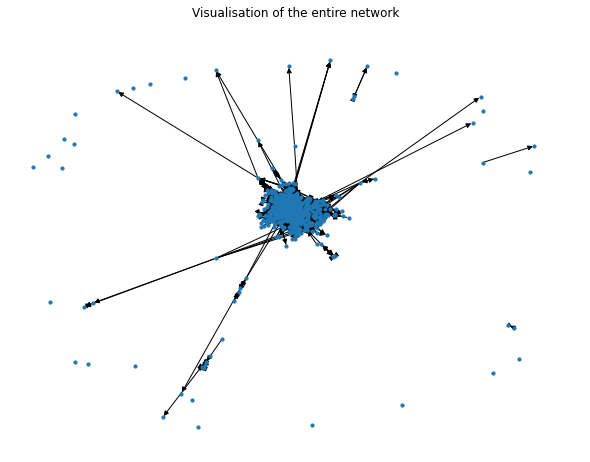

In [16]:
plt.figure(figsize=(8,6))
nx.draw(G, node_size=10)
_ = plt.title('Visualisation of the entire network')

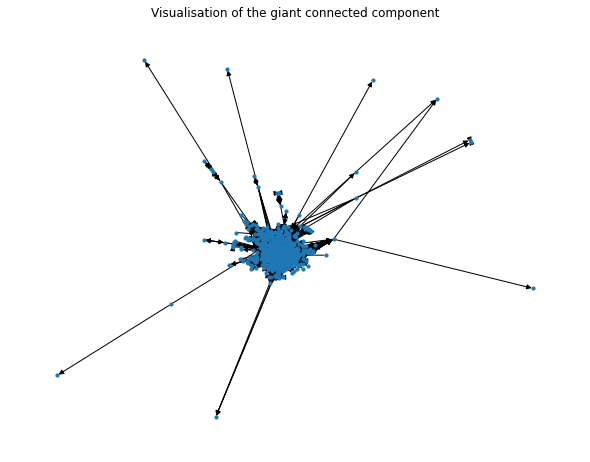

In [17]:
plt.figure(figsize=(8,6))
nx.draw(G_gc,node_size=10)
_ = plt.title('Visualisation of the giant connected component')

For a better visualisation of the giant connected component, an undirected graph is created from the GCC and drawn using ForceAtlas. For this visualisation node colors are based on status, where deceased characters are colored red and others are blue. Node sizes are based on the character's number of connections.

In [18]:
#Creating undirected graph using the giant connected component
UG_gc = G_gc.to_undirected()
degree_list=list(UG_gc.degree())
nodes, degree = map(list, zip(*degree_list))

In [19]:
#Getting node status and assigning each status a color
status = nx.get_node_attributes(UG_gc,'status')
color_status = {'Alive': [47/256,120/256,205/256], 'Deceased': [234/256,89/256,75/256], 'Dead': [234/256,89/256,75/256], 'Uncertain': [47/256,120/256,205/256]}

#Creating color- and sizemap for nodes before plotting the network
colormap = []
sizemap = []
for node in UG_gc.nodes():
    colormap.append(color_status[status[node][0]])
    sizemap.append(UG_gc.degree(node)*5 + 1)

100%|██████████| 2000/2000 [00:06<00:00, 302.15it/s]


BarnesHut Approximation  took  2.29  seconds
Repulsion forces  took  3.77  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.25  seconds


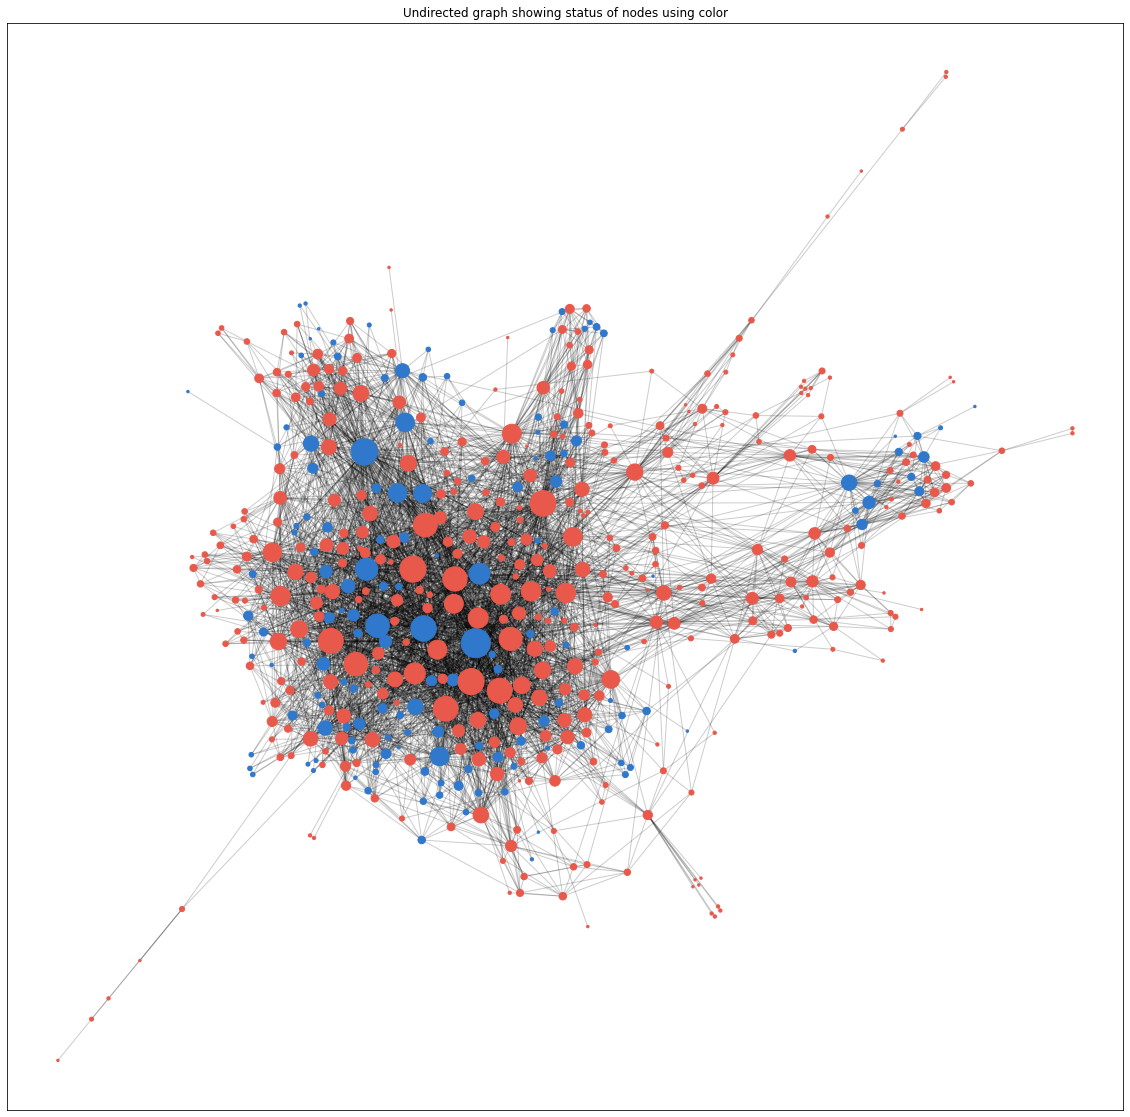

In [20]:
#Plotting network using ForceAtlas
plt.figure(figsize=(20,20))
forceatlas2 = ForceAtlas2(edgeWeightInfluence=1, scalingRatio=2)
positions = forceatlas2.forceatlas2_networkx_layout(UG_gc,pos=None,iterations=2000)
nx.draw_networkx_nodes(UG_gc,
                       positions,
                       node_color=colormap,
                       node_size=sizemap)
nx.draw_networkx_edges(UG_gc,positions,edge_color="black",alpha=0.2)
_ = plt.title('Undirected graph showing status of nodes using color')

Hopefully you now have a better understanding of the network size and scale. While the visualization using the draw function in networkx did not provide much information regarding the network, the ForceAtlas really helped visualize the network more clearly. From that it is clear to see the great amount of connections in the network as well as comparing the differences between the number of connections individual characters have. There is not any one character that stands out as the most connected character by far. The biggest nodes are multiple characters that have a very similar amount of connections. Very few characters were isolated in the original network and most of the characters are somehow connected to each other. This is why there is not that much difference in the size of the giant connected component and the original network.

### 3.3 Word Clouds

It was decided to use word clouds for each one of the great houses as the second part of the network analysis. The end goal of creating word clouds was to be able to see the differences in the words and page text between the characters belonging to each one of the major houses. This part of the report will go over how these word clouds were created.

First things first was to create a list called `houses_list` to store every allegiance that appears in the network. Then a list of `houses` was created from the `houses_list` by including only allegiances which relate to a households. The `houses` list was then used to create a dictionary where the keys are the unique houses and the values for each key is an array of words.

In [21]:
#Getting a list of all available allegiances
houses_list = []
for node in G_gc.nodes:
    for allegiance in G_gc.nodes[node]['allegiance']:
        houses_list.append(allegiance)
#Removing duplicates
houses_list = list(set(houses_list))

#Only include allegiances which are a House
houses = []
for h in houses_list:
    if 'House' in h:
        houses.append(h)
        
#Creating a dictionary of the houses
houses_dict = {}
for h in list(set(houses)):
    houses_dict[h] = []

In [22]:
#Creating a list of stopwords and the pattern used to extract headers
stops = list(set(stopwords.words("english")))
header_pattern = '==+ *.*? *==+'
#The lemmatizer used
wnl = nltk.WordNetLemmatizer()

Next was to loop through each character page to extract all the words the page contained. Headers were removed using the `header_pattern` as well as all character names by looping through all the nodes in the network. The text was tokenized using the `WordPunctTokenizer` and all relevant tokens were saved in the word arrays for corresponding house keys in the `houses_dict` dictionary. 

**RegEx explanation:**
Two regex patterns were used when excluding character names from the text pages.
* **name_pattern1/name_pattern2**: `(*character name*)(?:[^a-zA-Z])` this pattern was used to avoid cases where a character name was a substring in another word and the word would therefore be broken up. (i.e a character named Lann would make the word Lannister turn into ister). This pattern matches a character name that is then followed by a non-alphabetic letter. The pattern is used in a re.sub where the match is removed. 

In [23]:
#Looping through each character page
for node in G_gc.nodes:
    name = node.replace(' ','_')
    with open('./GoT_characters/'+name+'.txt') as f:
        text = f.read()
        f.close() 
    
    #Filtering out the headers of sections
    new_text = re.sub(header_pattern,'',text)

    #Excluding character names
    for n in G_gc.nodes:
        #Excluding possesive versions of the name (i.e. Arya's)
        n_poss = n+"'s"
        #Removing only where name is not a substring in another word
        name_pattern1 = '('+n+')(?:[^a-zA-Z])'
        new_text = re.sub(name_pattern1,'',new_text)
        new_text = re.sub(n_poss,'',new_text)
        #Splitting name in order to remove characters' first names
        name_list = n.split(' ')
        name_pattern2 = '('+name_list[0]+')(?:[^a-zA-Z])'
        new_text = re.sub(name_pattern2,'',new_text)

    #Tokenizing the text with WordPunctTokenizer()
    tokens = []
    tokens = WordPunctTokenizer().tokenize(new_text)

    #For each token, only include if it's not punctuation, if it's not a stopword and if it is longer than one letter when lemmatized
    #Saving results in the corresponding house array in dictionary, results are saved in lowercase and lemmatized.
    for token in tokens:
        if token.isalpha() and token.lower() not in str(stops).lower():
            for a in G_gc.nodes[node]['allegiance']:
                if 'House' in a:
                    houses_dict[a].append(wnl.lemmatize(token.lower()))
                

Now that the dictionary `houses_df` stores a list of every word in the character pages for each character in each house the next step is to count the occurences of these words. To do that a dataframe is created called `house_df` that will be used to store each individual word that occurs in the text for each house, how many times it is repeated by characters that belong to the house, and to which house it belongs. A double for loop is used to do this, looping through the keys in `house_dict` and looping through the unique words in the word list for that key. The occurence of each unique word is then counted for that house and stored in the dataframe. **Warning: this cell takes a long time to run!**

In [24]:
#Creating a dataframe to store information about word count for each word in each house
house_df = pd.DataFrame({'word':[],'count':[],'house':[]})

#Looping through houses and words to count occurences of each word
for key in houses_dict:
    for w in list(set(houses_dict[key])):
        new_row = {'word':w, 'count':houses_dict[key].count(w), 'house':key}
        house_df = house_df.append(new_row, ignore_index=True)

Next up is calculating the tc-idf value of each word. This is done by looping through each word in the dataframe that appears in a character page for one of the top houses. The number of documents this word appears in is stored in a new dataframe column called `idf`. The `tc-idf` is then calculated by multiplying the `count` and `idf` column values for each row. **Warning: this cell takes a long time to run!**

In [25]:
#Total number of races
n = len(list(set(houses))) 
#List of the top houses which will be the houses used to create word clouds
top_houses = ['House Stark','House Lannister','House Targaryen','House Bolton',"House Baratheon of King's Landing",'House Tyrell','House Arryn','House Tully','House Martell','Dothraki']

#Looping through each word in the character pages of the top houses to calculate the tc-idf values
for w in house_df.loc[house_df['house'].isin(top_houses) == True, 'word']:
    doc_nums = house_df.loc[house_df.word == w,'word'].count()
    house_df.loc[house_df.word == w, 'idf'] = math.log10(n/doc_nums)
house_df['tc-idf'] = house_df['count'] * house_df['idf']

Now the rounded up tc-idf value of each word for every house are stored in an array and that array is used to draw the word cloud for each house. A mask was used for the word clouds that make the clouds take a form associated to the house crest. Each word cloud was drawn using the wordcloud function and saved in a png format.

In [26]:
#Declare arrays used to draw word clouds
wc_stark = []
wc_lannister = []
wc_targaryen = []
wc_bolton = []
wc_baratheon = []
wc_tyrell = []
wc_arryn = []
wc_tully = []
wc_martell = []

#Store rounded up tc-idf values in the word cloud arrays
for index, row in house_df.iterrows():
    if row['house'] == 'House Stark':
        wc_stark += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Lannister':
        wc_lannister += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Targaryen':
        wc_targaryen += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Bolton':
        wc_bolton += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == "House Baratheon of King's Landing":
        wc_baratheon += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Tyrell':
        wc_tyrell += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Arryn':
        wc_arryn += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Tully':
        wc_tully += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == "House Martell":
        wc_martell += [row['word']]*math.ceil(row['tc-idf'])

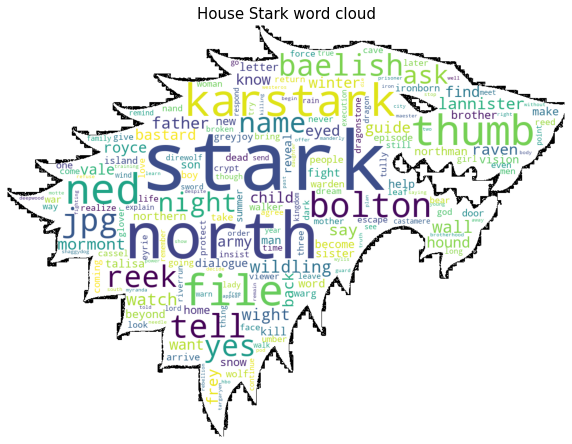

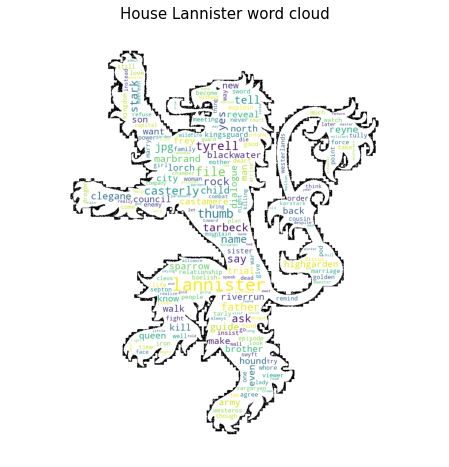

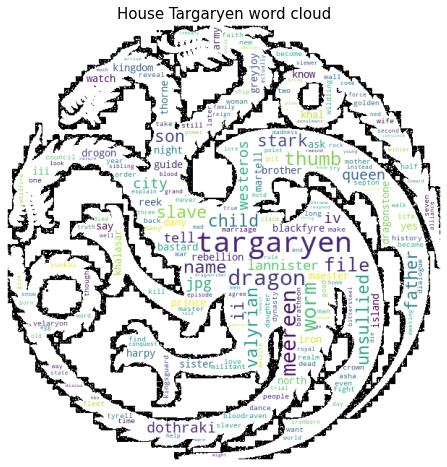

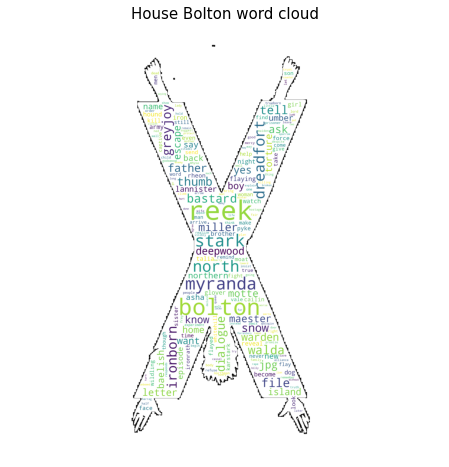

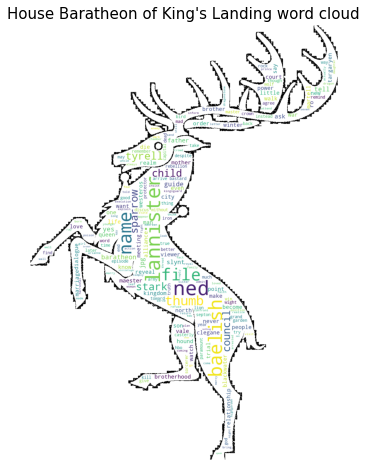

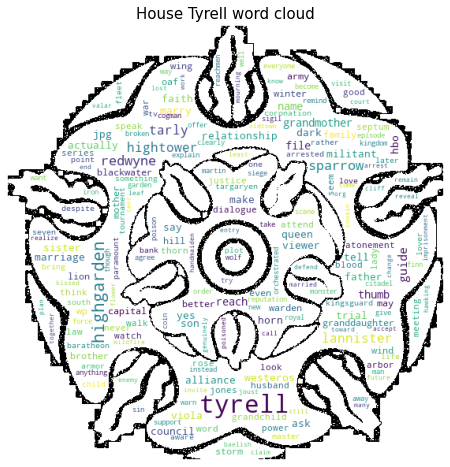

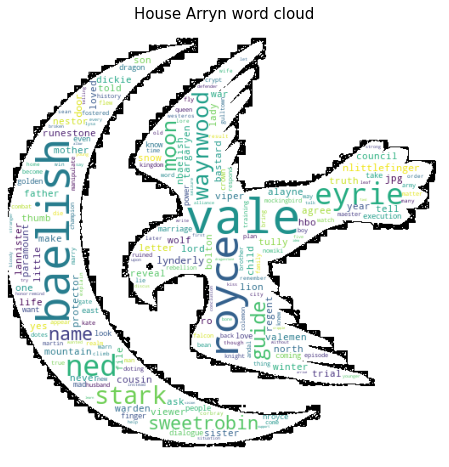

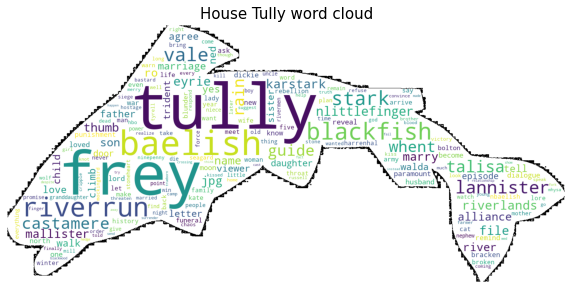

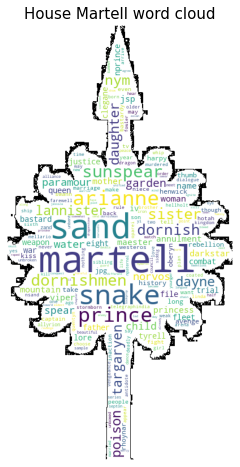

In [27]:
#A list of the word cloud arrays for the houses, the wc_names relate to the names of the cloud mask figures used
wcs = [wc_stark,wc_lannister,wc_targaryen,wc_bolton,wc_baratheon,wc_tyrell,wc_arryn,wc_tully,wc_martell]
wc_names = ['wc_stark','wc_lannister','wc_targaryen','wc_bolton','wc_baratheon','wc_tyrell','wc_arryn','wc_tully','wc_martell']

#Loop through each house and draw the word cloud
for i in range(len(wcs)):
    #Declare the cloud mask used, different one for each house
    cloud_mask = imageio.imread(wc_names[i]+'.jpg')
    wordcloud = WordCloud(
                          background_color='WHITE',
                          mask = cloud_mask,
                          contour_width=1, contour_color='black',
                          collocations=False
                         ).generate(' '.join(map(str,wcs[i])))

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud)
    plt.title(top_houses[i]+' word cloud',fontsize=15)
    plt.axis('off')
    #Save word cloud as a figure
    plt.savefig(wc_names[i]+'.png')
    plt.show()

#### Word cloud analysis

**Stark**: The words that jump out right away when looking at the word cloud for House Stark are words like *stark*, *north*, *karstark*, *thumb*, *ned*, and *bolton* The word *Stark* is obviously a reference to the House name and *Ned* is a nickname for Eddard Stark, the head of House Stark. The word *north* is very fitting since House Stark is the royal house of the Kingdom in the North. *Karstark* and *Bolton* are other houses in the north which both have a lot of history with House Stark. The word *night* is also fitting since House Stark often references the Long Night.

**Lannister**: In the Lannister word cloud, many of the larger words are references to houses. *Lannister* is an obvious one, *tyrell* is a reference to House Tyrell and *tarbeck* to house Tarbeck. Both House Tyrell and House Tarbeck have a lot of history with House Lannister. The word *casterly* is a reference to Casterly Rock which is a castle ruled by House Lannister. The word *blackwater* is most likely a reference to Blackwater Bay which is where King‘s Landing is located.

**Targaryen**: The biggest word in the Targaryen word cloud is the word *targaryen*. Most of the other bigger words are very fitting for House Targaryen. The word *dragon* is very fitting as dragons are a big part of House Targaryen, so much so that even their sigil is a dragon. Other words are words like *dothraki* and *unsullied* are both groups of warriors that followed Daenerys Targaryen in her pursuit of the throne. *Meereen* is one of the cities where Daenerys and her army freed slaves.

**Baratheon**: The most obvious words in the Baratheon word cloud are words like *ned*, *lannister*, *baelish*, *stark*, and *sparrow*. *Ned* and *Stark* are references to Eddard Stark which is the head of House Stark and longtime friend of Robert Baratheon and *Baelish* is a reference to Petyr Baelish. *Lannister* is a reference to House Lannister which is largely connected with House Baratheon since Robert Baratheon married Cersei Lannister. *Sparrow* is a reference to High Sparrow, which is a religious movement that had big impact in King‘s Landing. 

**Bolton**: In the word cloud for House Bolton the biggest words are *bolton*, *reek*, *myranda*, *dreadfort*, *greyjoy*, and *ironborn*. *Bolton* is obviously the house name and *Dreadfort* is a castle in the north, home of House Bolton. The words *reek* and *greyjoy* are both a reference to Theon Greyjoy who was captured, tortured, and forced into servitude by House Bolton. The word *ironborn* is also connected to Theon Greyjoy since the ironborns are the people of House Greyjoy.

**Arryn**: A few words in the Arryn word cloud stand out. The words *baelish*, *vale*, *eyrie*, *royce*, and *waynwood* are some of the biggest word in this cloud. *Eyrie* is the stronghold of House Arryn and is located in the *Vale* of Arryn. *Royce* is a reference to House Royce which was used to rule over the Vale until it was deposed by House Arryn. Petyr *Baelish* married Lysa Arryn and after her death became the Lord Protector of the Vale. House *Waynwood* is a vassal house which holds fealty to House Arryn.

**Tully**: The biggest words in the Tully word cloud are the words *tully*, *frey*, *baelish*, *blackfish*, and *riverrun*. *Tully* is obviously the house name and *frey* is a reference to House Frey which is the former great house of the Riverlands that has a lot of history with House Tully. House Tully and House Frey have a lot of history and have both been, at some point, the great house of the Riverlands. *Riverrun* is the seat of House Tully in the Riverlands and *blackfish* is a reference to Brynden Tully, who was a knight and member of House Tully. *Baelish* is Petyr Baelish who was very much associated with the Tully family and ended up marrying one of the Tully girls, Lysa Tully.

**Tyrell**: There are not that many big words in the Tyrell word cloud, but a few of the more obvious ones are *tyrell*, *highgarden*, *hightower*, *redwyne*, and *grandmother*. *Tyrell* is obviously the house name and *Highgarden* was the seat of House Tyrell. *Hightower* is a lighthouse in Westeros which is a the seat of House Hightower which is a powerful family with strong ties to House Tyrell. House *Redwyne* is another family which has a close relationship to their overlord, House Tyrell. The word *grandmother* is also quite fitting for House Tyrell as one of the main relationships of House Tyrell that is covered in the series is between Margaery Tyrell and her grandmother, Lady Olenna Tyrell.

**Martell**: The words in the House Martell word cloud that jump out right away are *martell*, *sand*, *snake*, *sunspear*, *prince*, *arianne*, and *dornishmen*. *Martell* is the house name and the *sunspear* is both their sigil and the name of the seat of House Martell, the capital of Dorne. The words *sand* and *snake* are both a reference to the eight bastard born daughters of *Prince* Oberyn Martell. They were often referred to as the Sand Snakes. *Dornishmen* is a reference to people born in Dorne, which is where the seat of House Martell is located. *Arianne* is a reference to Arianne Martell, which is the daughter of Prince Doran Martell and heir to House Martell.


### 3.4 Sentiment

The third network analysis applied to the network was a sentiment analysis. In this part the goal was to evaluate the sentiment of each character, as well as each major house. Hopefully, this will be a fun way to see which of the characters (and houses) have a more negative storyline and which ones are more positive. Most people who have followed the series can probably guess which characters/houses will be the more negative and positive ones so it will be interesting to see if the analysis agrees. Both LabMT and Vader were used to calculate the sentiment of each character as well as the overall sentiment of each one of the great houses. This part of the report will explain how the sentiment was calculated using these two methods.

The first thing was to define a function that cleans the character page text and returns the individual cleaned sentences from each page.

*  `(?:== *Biography *==)(.*?)(?:== *See also *==)` was used to leave out the table at the top, since most of the useful text starts with the header Biography and ends with See also. 
*  `(?:== *(.*?)*==)` removes all the headers in the text.
*  `\[\[File:(.*?)\]\]` removes all the files in the text, mostly removing all the images.
*  Some of the link are in the following format [[text1|text]], for those instances the first bracket was removed as well as text1, and text2 only left behind, for that the following reggex was used:  `\[\[[\(\)\'a-zA-Z\s\d]*\|`. After many different symbols were removed as well, which removed the closing bracket.
* `\\\\n` removed the line breaks in the text.
* Some of the links were in the following format <ref> Link </ref>, therefore the following reggex was used to remove those links `<ref(.*?)>(.*?)</ref`.
* Finally all the text was split using the delimiter . to split each sentence up.

In [28]:
#Function used to clean the character page text and extracting sentences.
def clean_text(text):
    pattern = "(?:== *Biography *==)(.*?)(?:== *See also *==)"
    text = re.findall(pattern, text)
    pattern = "(?:== *(.*?)*==)"
    text = re.sub(pattern,'',text[0]) 
    pattern = '\[\[File:(.*?)\]\]'
    text = re.sub(pattern, '',text)
    pattern = "\[\[[\(\)\'a-zA-Z\s\d]*\|"
    text = re.sub(pattern, '',text)
    text = text.replace('[[','')
    text = text.replace(']]','')
    text = text.replace('{{','')
    text = text.replace('}}','')
    text = text.replace('=','')
    pattern = '\\\\n'
    text = re.sub(pattern, '', text)
    pattern = '<ref(.*?)>(.*?)</ref>'
    text = re.sub(pattern, '', text)
    text = text.replace('|','')
    text = text.split('.')
    return text

In [29]:
#Cleaning character pages using the clean_text function. 
#Saving the array of sentences in a dataframe called data where the keys are the characters.
data = {}
for node in UG_gc.nodes:
    name = node.replace(' ','_')
    with open('./GoT_characters/'+name+'.txt') as f:
        text = f.read()
        f.close() 
    text = clean_text(text)
    data.update({node: text})

#### 3.4.1 LabMT

When using the LabMT sentiment analysis, words from the file LabMT.csv are used, all the words from the file were read and saved in a list called LabMT_list.

In [30]:
#LabMT file opened and saved in a list
file = open('./LabMT.csv')
csvreader = csv.reader(file)
LabMT_list = []
for row in csvreader:
    LabMT_list.append(row)
LabMT_list=LabMT_list[1:]

A function was created takes in the wordlist that needs to be analysed, as well as the LabMT_list

In [31]:
#Function that calculates the senitment
def calc_sent(words_list, sentiment_list):
    sent_score = []
    for word in words_list:
        for sentiment in sentiment_list:
            if sentiment[0] == word:
                sent_score.append(float(sentiment[2]))
    return np.mean(sent_score)

In [32]:
#More cleaning done for the sentences in the dictionary created earlier
for key, value in data.items():
    for i, sentence in enumerate(value):
        value[i] = re.sub("[^a-zA-Z0-9, \ , \']+", "", sentence)

LabMT calculates its sentiment using tokens from the sentences, therefore each sentence needs to be tokenized.

In [33]:
wnl = nltk.WordNetLemmatizer()
LabMT = []
#All the characters read from the dictionary and saved in a list
char = list(data.keys())

#Going throug each character in the dictionary
for node in char:
    word = data[node]
    tokens = []
    tokenizer = []
    #Tokenizing each word
    for w in word:
        token = WordPunctTokenizer().tokenize(w)
        tokens = tokens + token

    final_tokens = []
    #Lemmatizing each token and putting to lower case
    for token in tokens:
        final_tokens.append(wnl.lemmatize(token.lower()))

    #Calculating average score for each node using the LabMT wordlist and adding as an attribute
    char_sent_score = calc_sent(final_tokens, LabMT_list)
    LabMT.append(char_sent_score)
    UG_gc.nodes[node]['LabMT'] = char_sent_score

#### 3.4.2 LabMT visualization

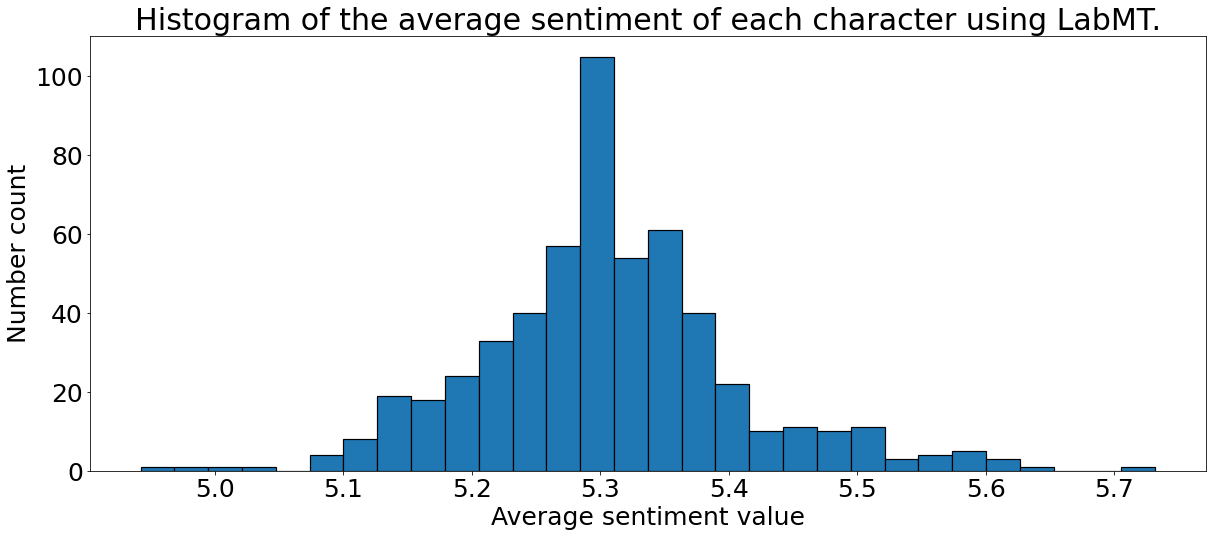

In [34]:
plt.figure(figsize = (20,8))
plt.hist(LabMT, bins = 30, edgecolor='black', linewidth=1.2)
plt.show
plt.ylabel('Number count',fontsize=25)
plt.xlabel('Average sentiment value',fontsize=25)
plt.xticks(fontsize=25)
plt.title('Histogram of the average sentiment of each character using LabMT.',fontsize=30)
_ = plt.yticks(fontsize=25)
plt.savefig('Sentiment_LabMT.png')

In [35]:
all_LabMT = []
for node in char:
    all_LabMT.append([node, UG_gc.nodes[node]['LabMT']])
        
happiest_char = sorted(all_LabMT, key = lambda i: i[1], reverse=True)[0:10]
saddest_char = sorted(all_LabMT, key = lambda i: i[1], reverse=False)[0:10]
print("The happiest characters are: ",[x[0] for x in happiest_char])
print("The saddest characters are: ",[x[0] for x in saddest_char])

The happiest characters are:  ['Maron Martell', 'Dorna Lannister', 'Alys Arryn', 'Lomas Longstrider', 'Myriah Martell', 'Ryger Rivers', 'Serra Frey', 'Minisa Tully', 'Sarra Frey', 'Theomar Smallwood']
The saddest characters are:  ['Garrison Fowler', 'Burton Crakehall', 'Gwayne Gaunt', 'Harlan Hoare', 'Joffrey Dayne', 'Raymun Darry', 'Meria Martell', 'Imry Florent', 'Johanna Lannister', 'Albin Manwoody']


#### 3.4.3 Vader

Vader uses the whole sentence for the analysis but not only the tokens like LabMT. A function was created as well for Vader where eacth sentence is analyzed, the function returns a mean of the compound score for each sentence, the compound score is the negative score and the positive score combined.

In [36]:
def calc_sent_Vader(word_list):
    sent_score = []
    analyzer = SentimentIntensityAnalyzer()
    for word in word_list:
        vs = analyzer.polarity_scores(word)
        sent_score.append(vs['compound'])
    return np.mean(sent_score)         

In [37]:
Vader = []
char = list(data.keys())
#Going through all the characters
for node in char:
    word = data[node]
    #Each sentence for every character is analysed and the mean value of of the sentiment calculated
    char_sent_score = calc_sent_Vader(word)
    Vader.append(char_sent_score)
    #The sentiment is saved as an attribute for the node
    UG_gc.nodes[node]['Vader'] = char_sent_score

#### 3.4.4 Vader visualization

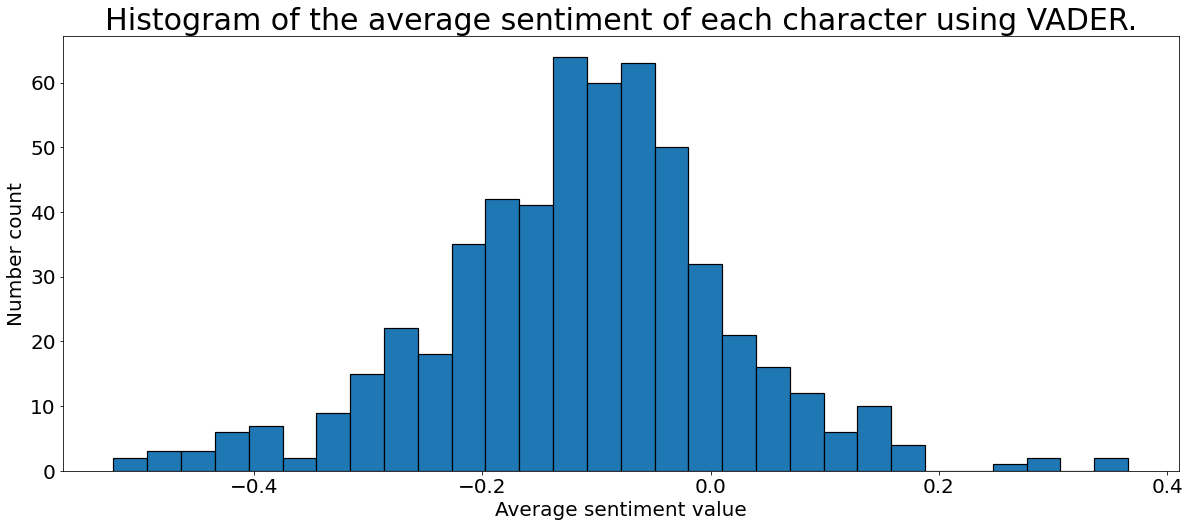

In [38]:
plt.figure(figsize = (20,8))
plt.hist(Vader, bins = 30, edgecolor='black', linewidth=1.2)
plt.show
plt.ylabel('Number count',fontsize=20)
plt.xlabel('Average sentiment value',fontsize=20)
plt.xticks(fontsize=20)
plt.title('Histogram of the average sentiment of each character using VADER.',fontsize=30)
_ = plt.yticks(fontsize=20)
plt.savefig('Sentiment_Vader.png')

In [39]:
all_Vader = []
for node in char:
    all_Vader.append([node, UG_gc.nodes[node]['Vader']])
        
happiest_char = sorted(all_Vader, key = lambda i: i[1], reverse=True)[0:10]
saddest_char = sorted(all_Vader, key = lambda i: i[1], reverse=False)[0:10]
print("The happiest characters are: ",[x[0] for x in happiest_char])
print("The saddest characters are: ",[x[0] for x in saddest_char])

The happiest characters are:  ['Richard Lonmouth', 'Qarlton Chelsted', 'Barth', 'Damon Morrigen', 'Walter Whent', 'Laena Velaryon', 'Garlan Tyrell', 'Aegon Ambrose', 'Lyle Bracken', 'Marya Seaworth']
The saddest characters are:  ['Elenei', 'Harlan Hoare', 'Garrison Fowler', 'Gwayne Gaunt', 'Torrhen Karstark', 'Qyle Corbray', 'Gelmarr', 'Hugh Hammer', 'Aggar', 'Haegon Blackfyre']


#### 3.4.5 Sentiment of the great houses

The sentiment was as well calculated for each of the Houses, that means that the average sentiment was calculated for each character that pledged allegiance to that House.

In [40]:
top_houses = ['House Stark','House Lannister','House Targaryen','House Bolton',"House Baratheon of King's Landing",'House Tyrell','House Arryn','House Tully','House Martell']
top_houses_names = ['Stark','Lannister','Targaryen','Bolton',"Baratheon",'Tyrell','Arryn','Tully','Martell']
LabMT_sent = np.zeros(len(top_houses))
LabMT_sent_std = np.zeros(len(top_houses))
char = list(data.keys())
LabMT_names = ['' for i in range(0, len(top_houses))]
#Iterating through each house
for i in range(0,len(top_houses)):
    temp_com = []
    #Iterating through every character and summing up their allegiance
    for node in char: 
        if top_houses[i] in UG_gc.nodes[node]['allegiance']:
            #Sentiments for characters with that allegiance saved in a list
            temp_com.append(UG_gc.nodes[node]['LabMT'])
    if temp_com == []:
        mean_temp_com = 0
    else:
        #The mean of the sentiment for each character calculated
        mean_temp_com = np.mean(temp_com)
    #The mean sentiment for each House saved in LabMT_sent
    LabMT_sent[i] = mean_temp_com
    LabMT_sent_std[i] = np.std(temp_com)

In [41]:
Vader_sent = np.zeros(len(top_houses))
Vader_sent_std = np.zeros(len(top_houses))
char = list(data.keys())
Vader_names = ['' for i in range(0, len(top_houses))]

#Iterating through each house
for i in range(0,len(top_houses)):
    temp_com = []
    for node in char:
        if top_houses[i] in UG_gc.nodes[node]['allegiance']:
            #Sentiments for characters with that allegiance saved in a list
            temp_com.append(UG_gc.nodes[node]['Vader'])
    if temp_com == []:
        mean_temp_com = 0
    else:
        #The mean of the sentiment for each character calculated
        mean_temp_com = np.mean(temp_com)
    #The mean sentiment for each House saved in Vader_sent
    Vader_sent[i] = mean_temp_com
    Vader_sent_std[i] = np.std(temp_com)

In [42]:
highest_LabMT = sorted(LabMT_sent, reverse=True)[0:3]
highest_vader = sorted(Vader_sent, reverse=True)[0:3]

LabMT_sent = list(LabMT_sent)

com1 = LabMT_sent.index(highest_LabMT[0])
com2 = LabMT_sent.index(highest_LabMT[1])
com3 = LabMT_sent.index(highest_LabMT[2])

print('Three happiest houses according to LabMT are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Vader_sent = list(Vader_sent)

com1 = Vader_sent.index(highest_vader[0])
com2 = Vader_sent.index(highest_vader[1])
com3 = Vader_sent.index(highest_vader[2])

print('Three happiest houses according to Vader are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Three happiest houses according to LabMT are:
House Martell
House Tyrell
House Tully
Three happiest houses according to Vader are:
House Tyrell
House Tully
House Baratheon of King's Landing


In [43]:
lowest_LabMT = sorted(LabMT_sent, reverse=False)[0:3]
lowest_Vader = sorted(Vader_sent, reverse=False)[0:3]

LabMT_sent = list(LabMT_sent)

com1 = LabMT_sent.index(lowest_LabMT[0])
com2 = LabMT_sent.index(lowest_LabMT[1])
com3 = LabMT_sent.index(lowest_LabMT[2])

print('Three saddest houses according to LabMT are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Vader_sent = list(Vader_sent)

com1 = Vader_sent.index(lowest_Vader[0])
com2 = Vader_sent.index(lowest_Vader[1])
com3 = Vader_sent.index(lowest_Vader[2])

print('Three saddest houses according to Vader are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Three saddest houses according to LabMT are:
House Lannister
House Stark
House Bolton
Three saddest houses according to Vader are:
House Lannister
House Bolton
House Martell


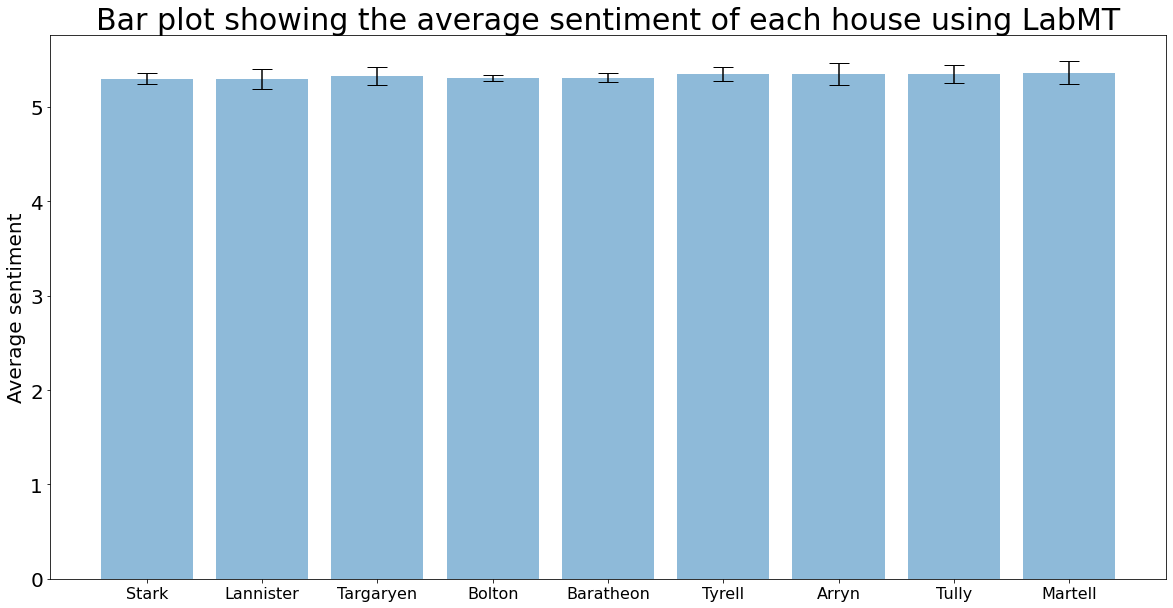

In [44]:
plt.figure(figsize = (20,10))
plt.bar(top_houses, LabMT_sent ,yerr = LabMT_sent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(top_houses, top_houses_names, fontsize=16, rotation = 0)
plt.yticks(fontsize=20)
plt.ylabel('Average sentiment',fontsize=20)
_ = plt.title('Bar plot showing the average sentiment of each house using LabMT', fontsize=30)
plt.savefig('Sentiment_LabMT_houses.png')

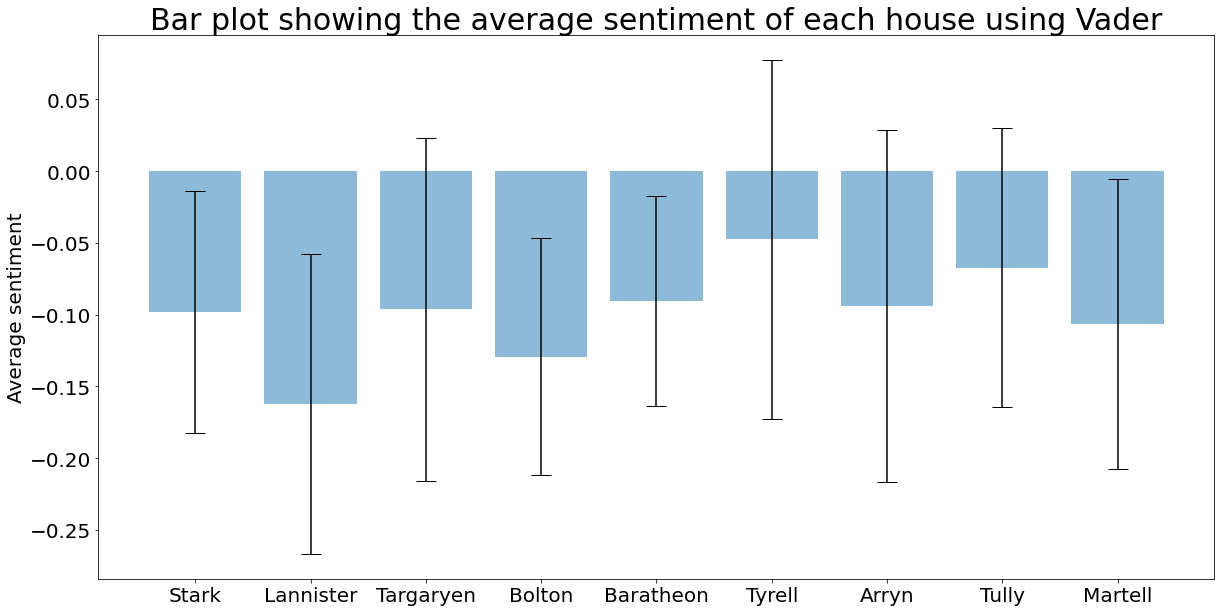

In [45]:
plt.figure(figsize = (20,10))
plt.bar(top_houses, Vader_sent ,yerr = Vader_sent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(top_houses, top_houses_names, fontsize=20, rotation = 0)
plt.yticks(fontsize=20)
plt.ylabel('Average sentiment',fontsize=20)
_ = plt.title('Bar plot showing the average sentiment of each house using Vader', fontsize = 30)
plt.savefig('Sentiment_Vader_houses.png')

Looking at the sentiment analysis it is clear that the overall sentiment of the series is more negative than positive, both for the characters and for the houses. This is not very surprising however, considering the storyline of the series. Two of the saddest houses, according to both LabMT and Vader are House Lannister and House Bolton. House Bolton is mostly known for their cruelty and torturing, so no surprise that they are among the saddest. When considering the betrayals and killings by House Lannister, the sentiment analysis results seem pretty accurate for their house as well.

### 3.5 Who has the most blood on their hands

Next was the analysis of which character has killed the most in total, as well as for each of the great houses. This should be interesting to see. Most people in this series have killed quite a few people, but who has killed the most people of all? 

For each house the death attribute was analysed, which contains the name of the person that killed the character associated with that node. For each house a graph was made of the deaceased characters with known killers, and the color of the node corresponds to their killer. A table was also made showing which color belongs to which killer, as well as how many they killed in that house.

In [46]:
#Getting every death attribute (every person that has killed someone)
death = nx.get_node_attributes(UG_gc,'death')
death_set = set()
death_all = []
#Making a list that only has the unique values of deaths (every person comes up once)
for val in death.values():
    death_set.add(val[0])
    death_all.append(val[0])
death_set = list(death_set)

#Counting how many occurances there are of that death instance (counting how many that person killed)
death_count = {}
for d in death_set:
    death_count.update({d: death_all.count(d)})

For each house a subgraph was created only containing the deceased characters in that particular House

In [47]:
top_houses = ['House Stark','House Lannister','House Targaryen','House Bolton',"House Baratheon of King's Landing",'House Tyrell','House Arryn','House Tully','House Martell']
nodes_houses = [[] for i in range(0,len(top_houses))]

#Iterating through every node
for node in UG_gc.nodes():
    #Only using those that are dead
    if (UG_gc.nodes[node]['status'][0] == 'Deceased') | (UG_gc.nodes[node]['status'][0] == 'Dead'):
        #Leaving out those that have unknown death for better visualization
        if UG_gc.nodes[node]['death'][0] != 'Unknown':
            if 'House Stark' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[0].append(node)
            if 'House Lannister' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[1].append(node)
            if 'House Targaryen' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[2].append(node)   
            if 'House Bolton' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[3].append(node)
            if  "House Baratheon of King's Landing" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[4].append(node)
            if  "House Tyrell" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[5].append(node)
            if  "House Arryn" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[6].append(node)
            if  "House Tully" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[7].append(node)
            if  "House Martell" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[8].append(node)

#Creating a subgraph with only the nodes of deceased and with known deaths for each house 
UG_house = [[] for i in range(0,len(top_houses))]
counter=0
for node in nodes_houses:
    s_graph = UG_gc.subgraph(node)
    UG_house[counter] = s_graph.copy()
    counter=counter+1

In [48]:
#Function that creates a random color
def random_color():
    rand_nr1 = random.randrange(0,100,1)/100
    rand_nr2 = random.randrange(0,100,1)/100
    rand_nr3 = random.randrange(0,100,1)/100
    return (rand_nr1, rand_nr2, rand_nr3)

#Function that chooses a random color for the death attribute(person), and counts how many instances there are of each input death attributes
def death_count_attribute(death):
    #Making a list that only has the unique values of deaths (every person comes up once)
    death_set = set()
    death_all = []
    for val in death.values():
        death_set.add(val[0])
        death_all.append(val[0])
    death_set = list(death_set)
    color_death = {}
    #Choosing a random color for each death 
    for i in range(0,len(death_set)):
        color = random_color()
        color_death.update({death_set[i]: color})
    #Counting how many occurances there are of that death instance (counting how many that person killed)
    death_count = {}
    for d in death_set:
        death_count.update({d: death_all.count(d)})
    return color_death, death_count

In [49]:
death = [[] for i in range(0,len(top_houses))]
color_death_house = [[] for i in range(0,len(top_houses))]
death_count_house = [[] for i in range(0,len(top_houses))]
counter = 0
for subgraph in UG_house:
    #Getting every death attribute (every person that has killed someone) in each subgraph
    death[counter] = nx.get_node_attributes(subgraph,'death')
    #Setting a color for each person, and counting how many they have kill
    color_death_house[counter], death_count_house[counter] = death_count_attribute(death[counter])
    counter = counter + 1

In [50]:
#Making a colormap for the graph for each house
counter=0
colormap_house = [[] for i in range(0,len(top_houses))]
for house in UG_house:
    for node in house.nodes():
        colormap_house[counter].append(color_death_house[counter][death[counter][node][0]])
    counter = counter+1

In [51]:
#Function that plots a table where the color is shown for each person and how many they have killed
def plot_colortable(colors, title, sort_colors=True, emptycols=0, count=0):
    cell_width = 412
    cell_height = 40
    swatch_width = 48
    margin = 12
    topmargin = 40


    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        name_count = name + ": " + str(count[name])
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7
        ax.text(text_pos_x, y, name_count, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )
    return fig

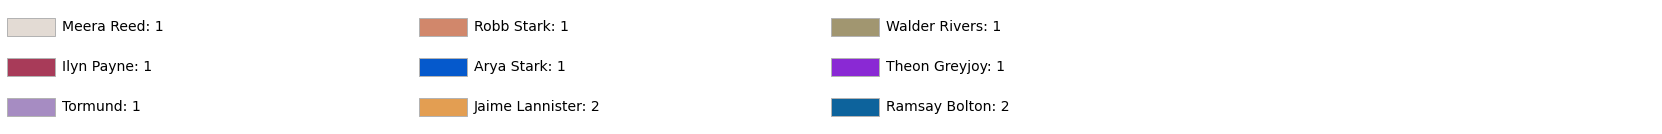

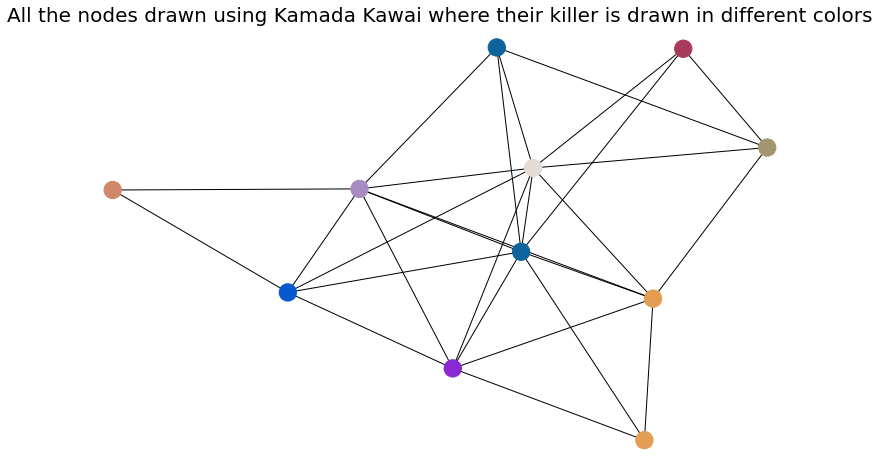

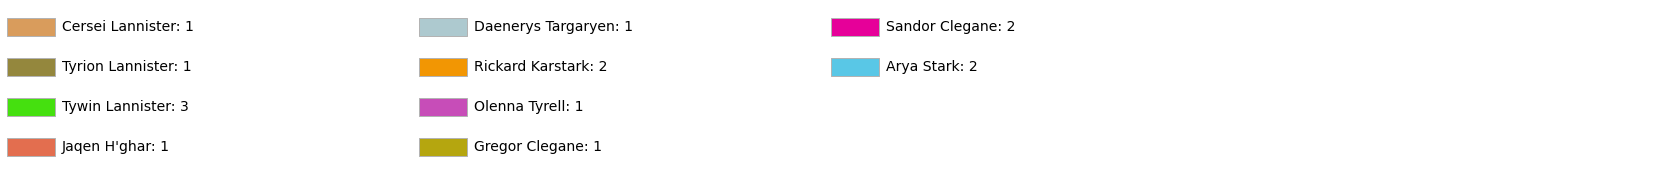

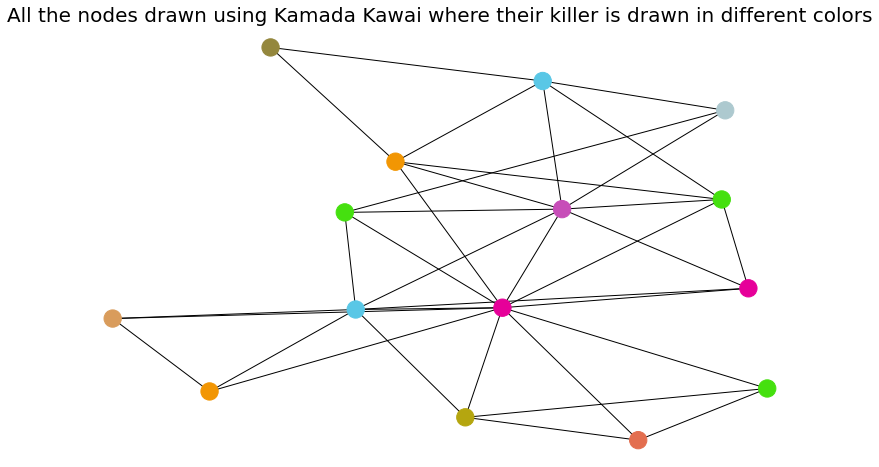

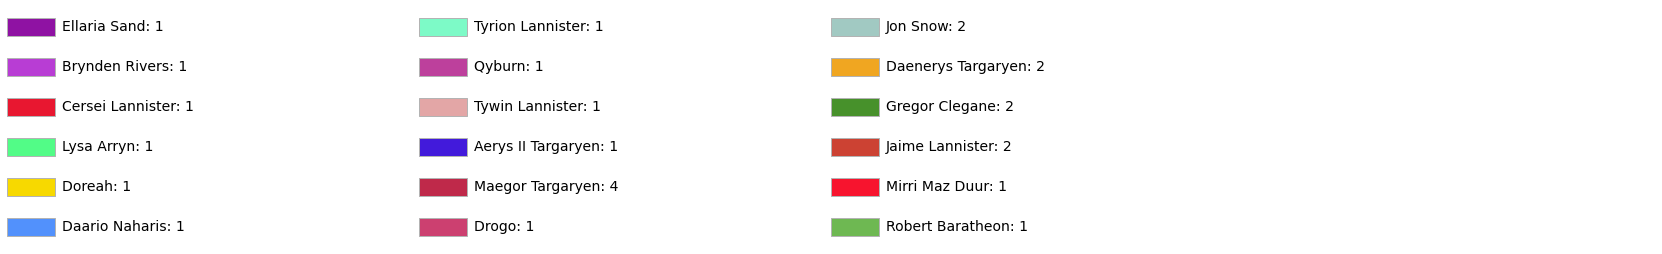

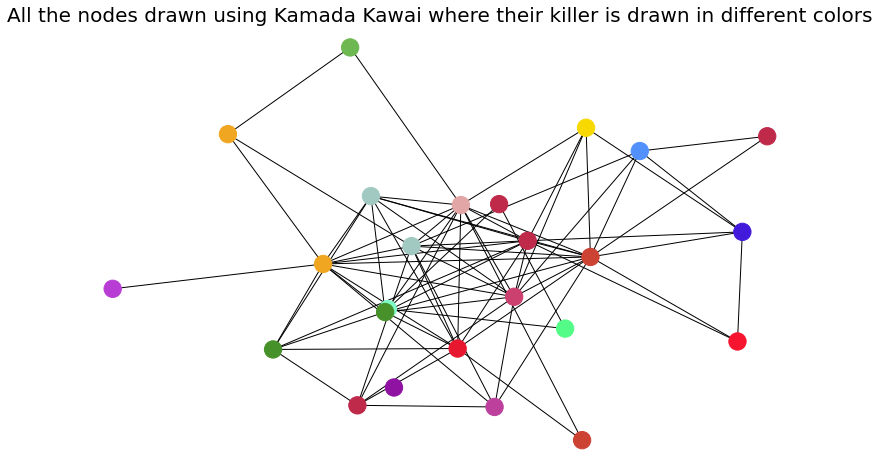

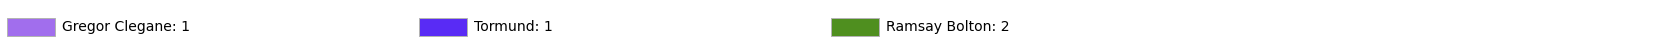

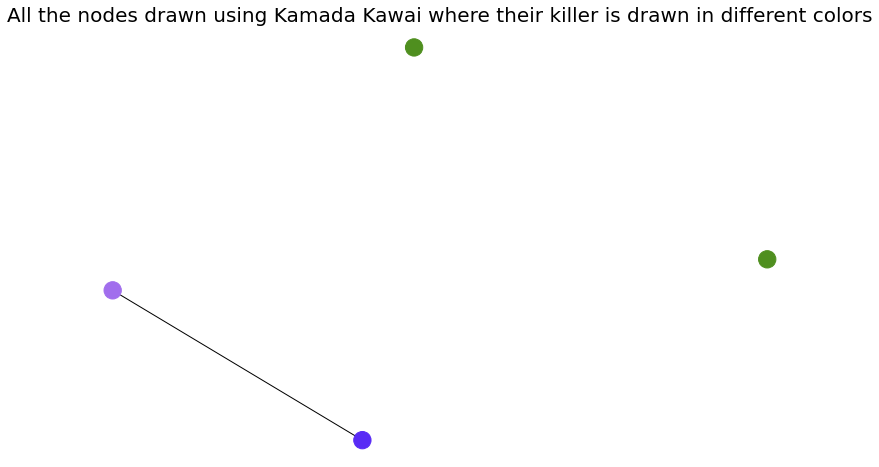

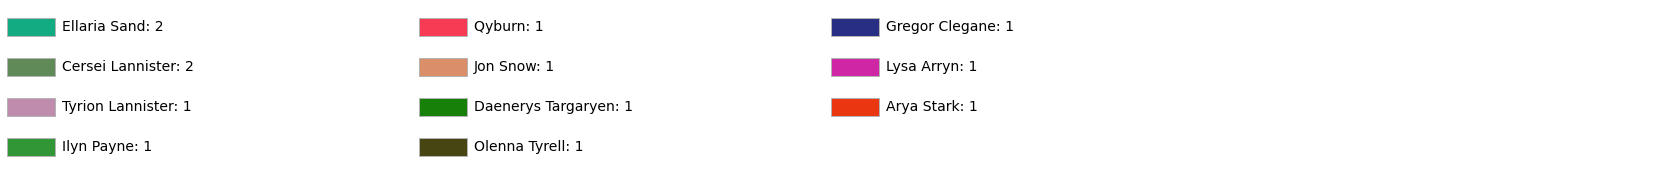

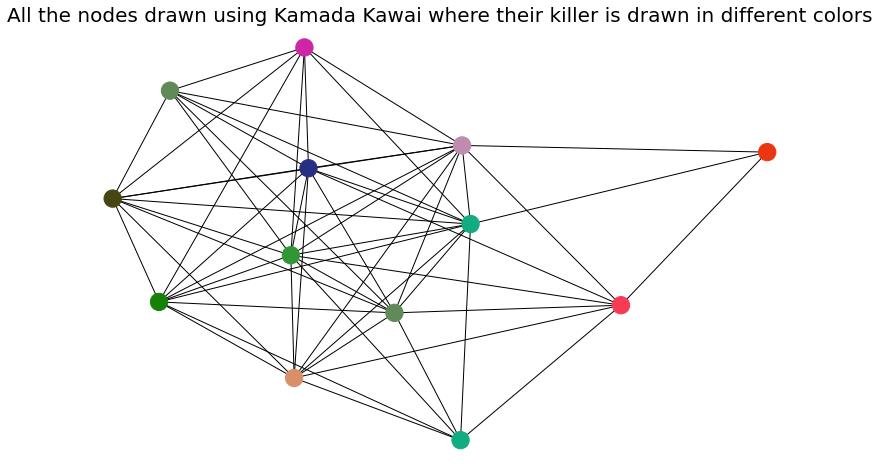

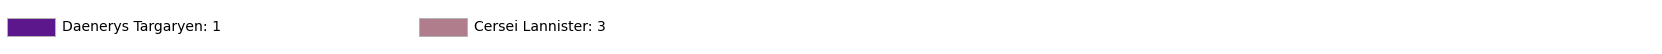

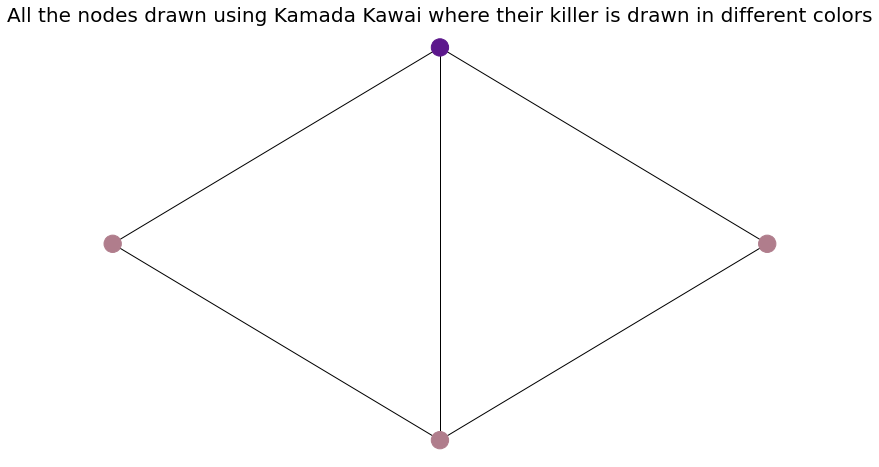

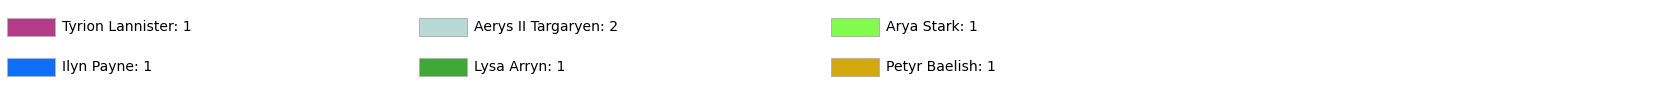

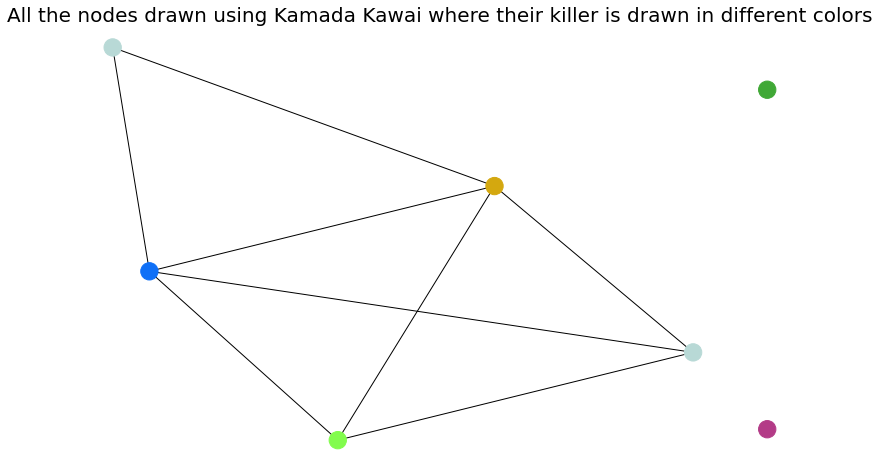

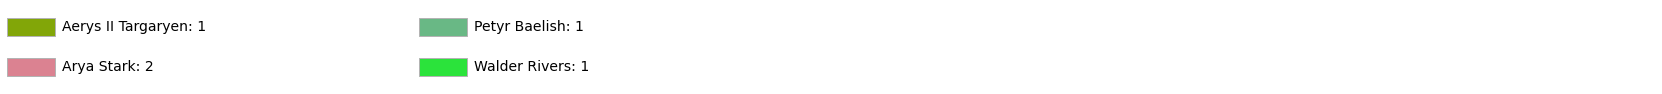

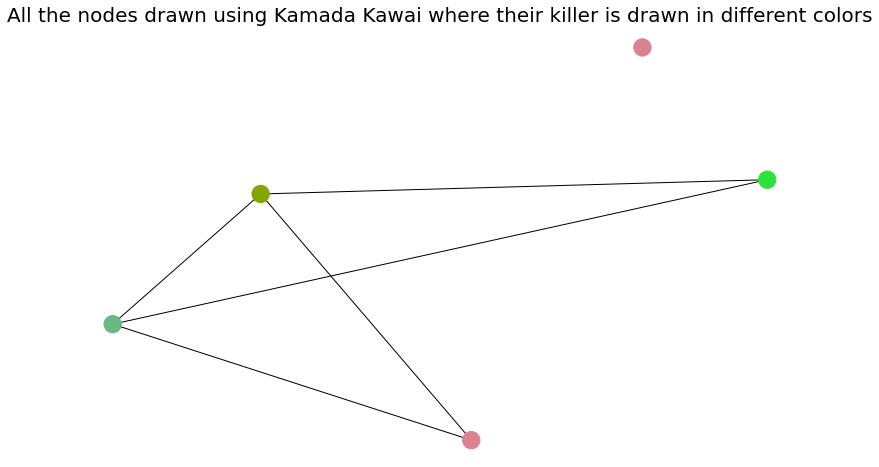

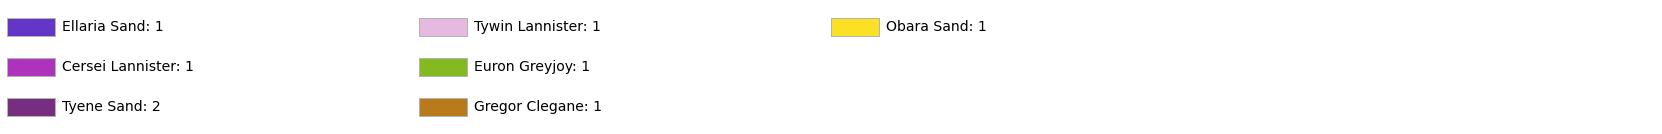

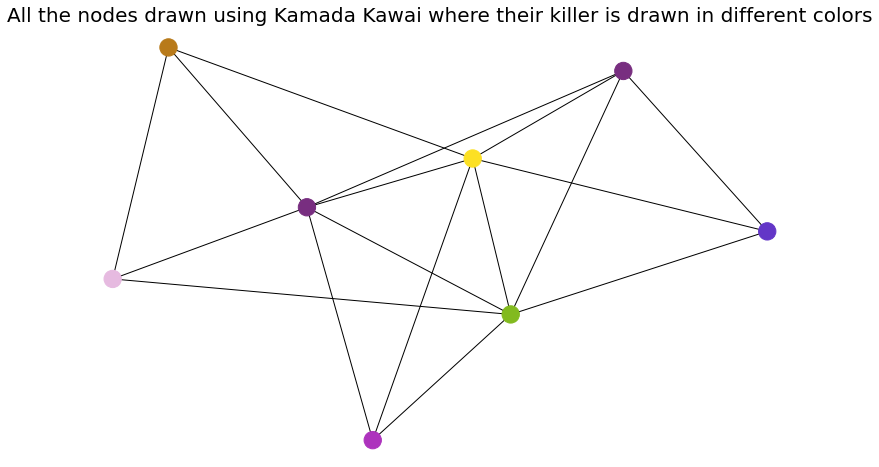

In [52]:
house_name = ['Stark', 'Lann', 'Targ', 'Bolton', 'Baratheon','Tyrell','Arryn','Tully','Martell']
#Iterrating through each house
for i in range(len(house_name)):
    #Creating a table with all the names of the killers and their color in the graph
    plot_colortable(color_death_house[i], "", sort_colors=False, emptycols=1, count = death_count_house[i])
    plt.savefig('Death_Colortable_'+house_name[i]+'.png')

    plt.show()
    #Creating a graph where each color corresponds to the killer of the owner of the node
    plt.figure(figsize=(10,6))
    nx.draw_kamada_kawai(
        UG_house[i], 
        nodelist=nodes_houses[i], 
        node_color=colormap_house[i]
    )
    _ = plt.title('All the nodes drawn using Kamada Kawai where their killer is drawn in different colors',fontsize=20)
    plt.savefig('Death_Plot_'+house_name[i]+'.png')

Many characters are missing in each graph since many of the death attributes are unknown, which probably has a large impact on the results. Most of the killers have only 1-2 kills for each House but there are a few that stand out though, Tywin Lannister has 3 kills in the Lannister family and Maegor Targaryen had 4 kills within his family. That indicates that the characters had some enemies within their own families. One another interesting thing to notice is that Cersei Lannister had 3 kills in the Tyrell family, which was actually their ally. As well as the fact that Arya Stark had a kill within almost all the families, which may not be surprising though since she has many kills in general.

### 3.6 Family Trees

The final network analysis was creating family trees for each one of the great houses. The main goal here was to be able to visualize the connections between families and further understand how incredibly connected all the families are, through marriages, and how many of the relationships in the series are very complicated and strange. 

The analysis was done using a program called [Gramps](https://gramps-project.org/blog/). When downloading the program, a `.py` file is downloaded called `familytreemaker.py`. To create the tree, the program is run using a `.txt` file containing information on the family in a very specific format as a parameter. Along with the `.txt` file, the name of the person used as the "head of the family" and the name of the output `.dot` file are included as parameters. Some changes were made to the `familytreemaker.py` file in order to make it work correctly for the great houses in this network.

To start, the input file `Family_Tree.txt` was created. This file needed to be in a specific format in order for it to work correctly with the program. Spouses should be in adjacent lines, followed by their children which were indented. Empty lines are used to distinguish between families. The program did not accept single parents, i.e one parent followed by children. Therefore, "bastard" children, i.e children who did not have two parents that were each others spouse, were added to the tree with an "Unknown spouse of ..." as the missing parent.

In [53]:
file_name = 'Family_Tree.txt'
#The names variable helps keep count of characters which have not yet been added to the file
names = list(UG_gc.nodes).copy()

#Looping through all characters in the giant component
for node in UG_gc.nodes:
    #All of the character's children are added to the bastards list, will be removed if the other parent is found
    bastards = UG_gc.nodes[node]['children'].copy()
    if 'Unknown' in bastards:
        bastards.remove('Unknown')
    text_file = open(file_name, "a")
    
    #Only add character if it has not been added before
    if node in names:
        if UG_gc.nodes[node]['spouse'] != ['Unknown']:
            
            #Adding all spouses to a list and looping through each one
            spouses = UG_gc.nodes[node]['spouse']
            for spouse in spouses:
                #Write name of character and it's spouse to the file
                text_file.write(node + '\n')
                text_file.write(spouse + '\n')
                if spouse in names:
                    names.remove(spouse)
    
                #Looping through each of the character's children
                for child in UG_gc.nodes[node]['children']:
                    #If the spouse is not in the character list, write the children under that spouse
                    if spouse not in UG_gc.nodes():
                        if child != 'Unknown':
                            text_file.write('\t' + child + '\n')
                            if child in bastards:
                                bastards.remove(child)
                    #If the spouse is in the character list
                    #only write the children under this spouse if the child is in the spouses children list 
                    elif child in UG_gc.nodes[spouse]['children'] and child != 'Unknown':
                        text_file.write('\t' + child + '\n')
                        if child in bastards:
                                bastards.remove(child)

                text_file.write('\n') 
        
        #Add bastards under undknown spouse of node
        if bastards:
            text_file.write(node + '\n')
            text_file.write('Unknown spouse of ' + node + '\n')
            for child in bastards:
                text_file.write('\t' + child + '\n')

            text_file.write('\n')
        
    text_file.close()

Running the `familytreemaker.py` program for each family. The outputting `.dot` file is then used to draw the family tree using graphviz. In order to run this part of the code, some installing needs to be done. Graphviz needs to be installed using Homebrew, so if Homebrew is not already available that needs to be installed. Then Graphviz can be imported by running the installing code cell below. This part of the assignment will be commented for your benefit and results displayed below.

In [54]:
#brew install graphviz

In [55]:
#%run ./familytreemaker.py -a 'Tytos Lannister' Family_Tree.txt -o 'Family_Tree_Lannister.dot'

In [56]:
#%%bash 
#dot -Tpng Family_Tree_Lannister.dot -o Family_Tree_Lannister.png

In [57]:
#%run ./familytreemaker.py -a 'Rickard Stark' Family_Tree.txt -o 'Family_Tree_Stark.dot' 

In [58]:
#%%bash 
#dot -Tpng Family_Tree_Stark.dot -o Family_Tree_Stark.png

In [59]:
#%run ./familytreemaker.py -a 'Maekar Targaryen' Family_Tree.txt -o 'Family_Tree_Targaryen.dot'

In [60]:
#%%bash 
#dot -Tpng Family_Tree_Targaryen.dot -o Family_Tree_Targaryen.png

In [61]:
#%run ./familytreemaker.py -a 'Roose Bolton' Family_Tree.txt -o 'Family_Tree_Bolton.dot'

In [62]:
#%%bash 
#dot -Tpng Family_Tree_Bolton.dot -o Family_Tree_Bolton.png

In [63]:
#%run ./familytreemaker.py -a 'Steffon Baratheon' Family_Tree.txt -o 'Family_Tree_Baratheon.dot'

In [64]:
#%%bash 
#dot -Tpng Family_Tree_Baratheon.dot -o Family_Tree_Baratheon.png

In [65]:
#%run ./familytreemaker.py -a 'Hoster Tully' Family_Tree.txt -o 'Family_Tree_Tully.dot'

In [66]:
#%%bash 
#dot -Tpng Family_Tree_Tully.dot -o Family_Tree_Tully.png

In [67]:
#%run ./familytreemaker.py -a 'Mors Martell' Family_Tree.txt -o 'Family_Tree_Martell.dot'

In [68]:
#%%bash 
#dot -Tpng Family_Tree_Martell.dot -o Family_Tree_Martell.png

In [69]:
#%run ./familytreemaker.py -a 'Luthor Tyrell' Family_Tree.txt -o 'Family_Tree_Tyrell.dot'

In [70]:
#%%bash 
#dot -Tpng Family_Tree_Tyrell.dot -o Family_Tree_Tyrell.png

In [71]:
#%run ./familytreemaker.py -a 'Jasper Arryn' Family_Tree.txt -o 'Family_Tree_Arryn.dot'

In [72]:
#%%bash 
#dot -Tpng Family_Tree_Arryn.dot -o Family_Tree_Arryn.png

Here below are all family trees that were created using Gramps displayed.

Stark Family Tree


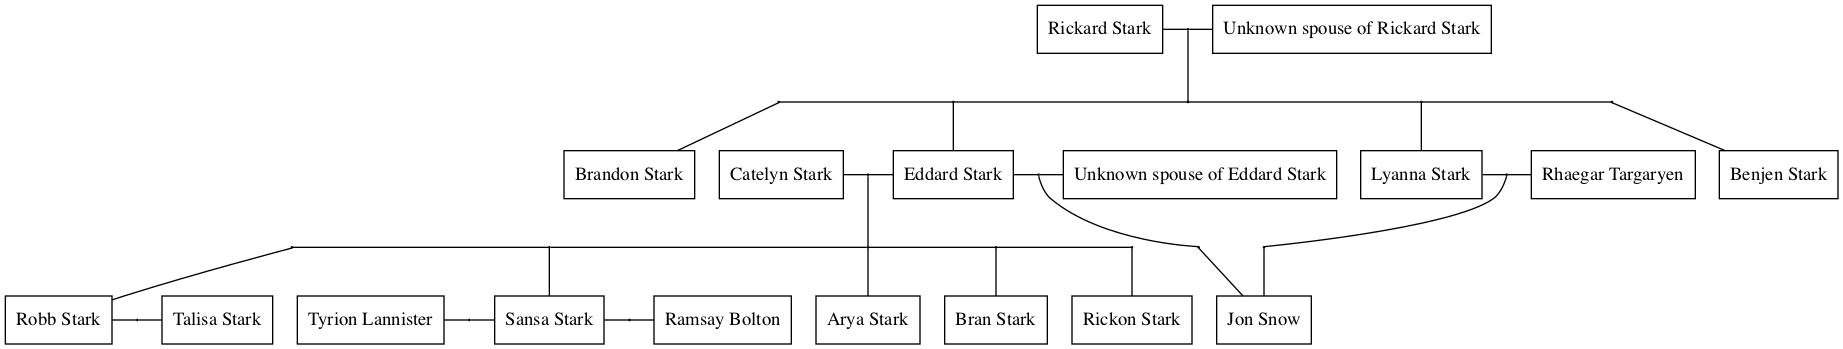



Lannister Family Tree


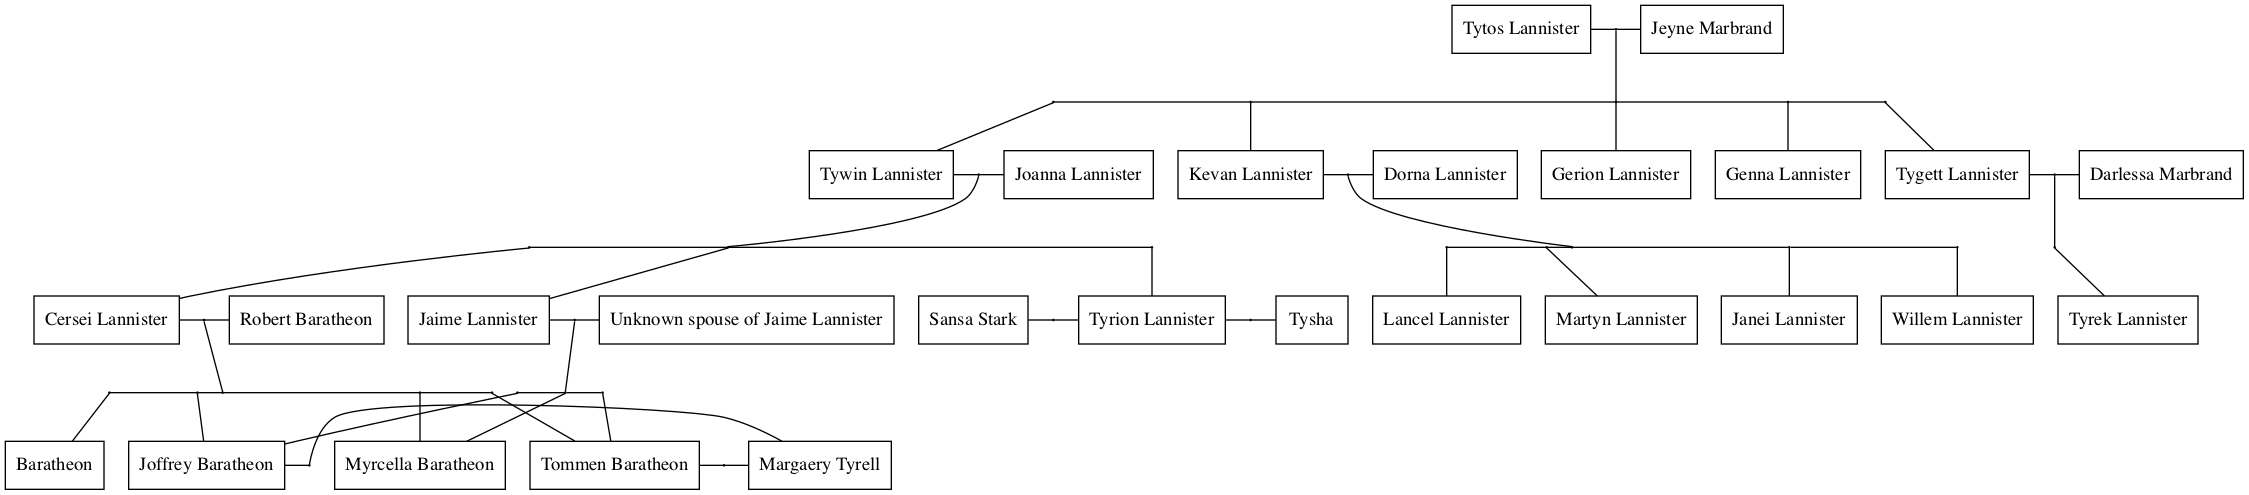



Targaryen Family Tree


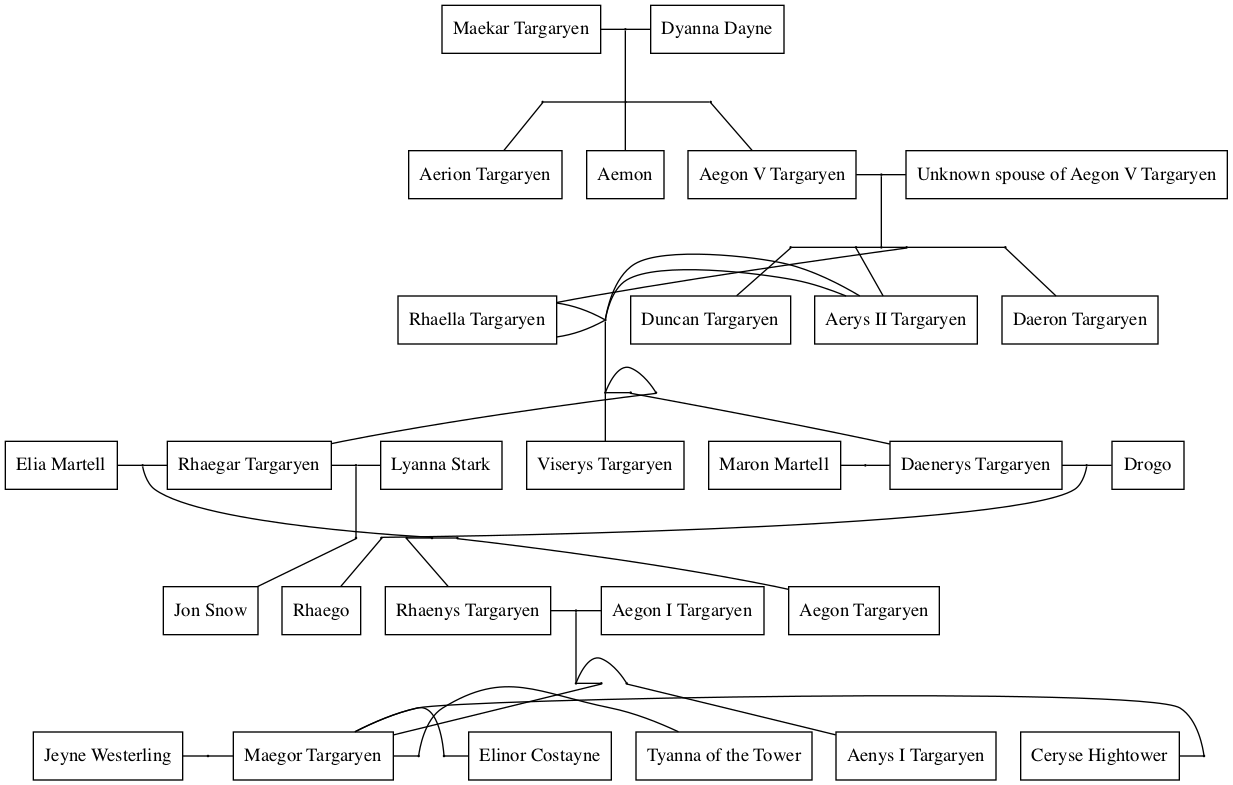



Bolton Family Tree


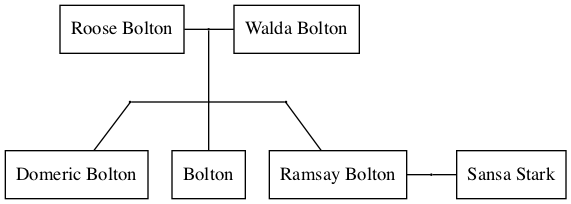



Baratheon Family Tree


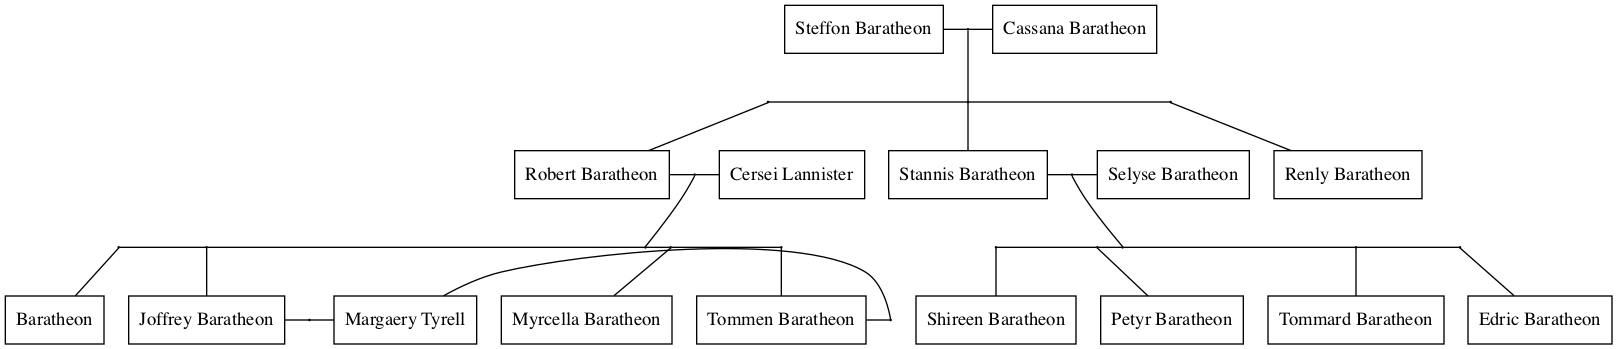



Tyrell Family Tree


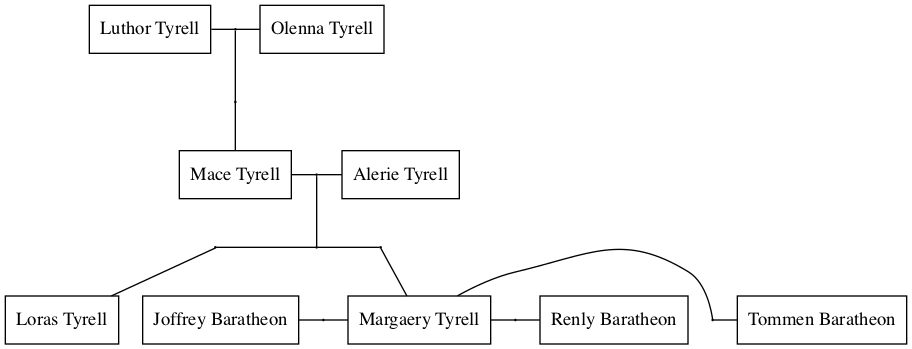



Arryn Family Tree


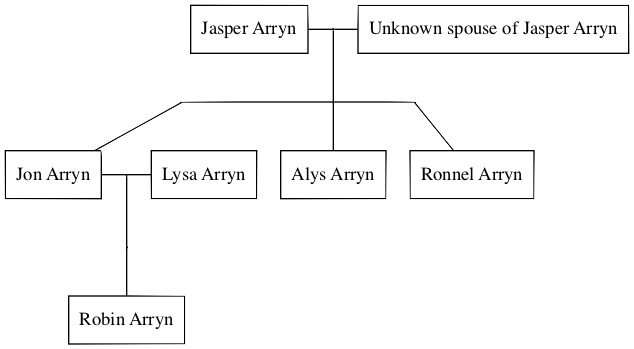



Tully Family Tree


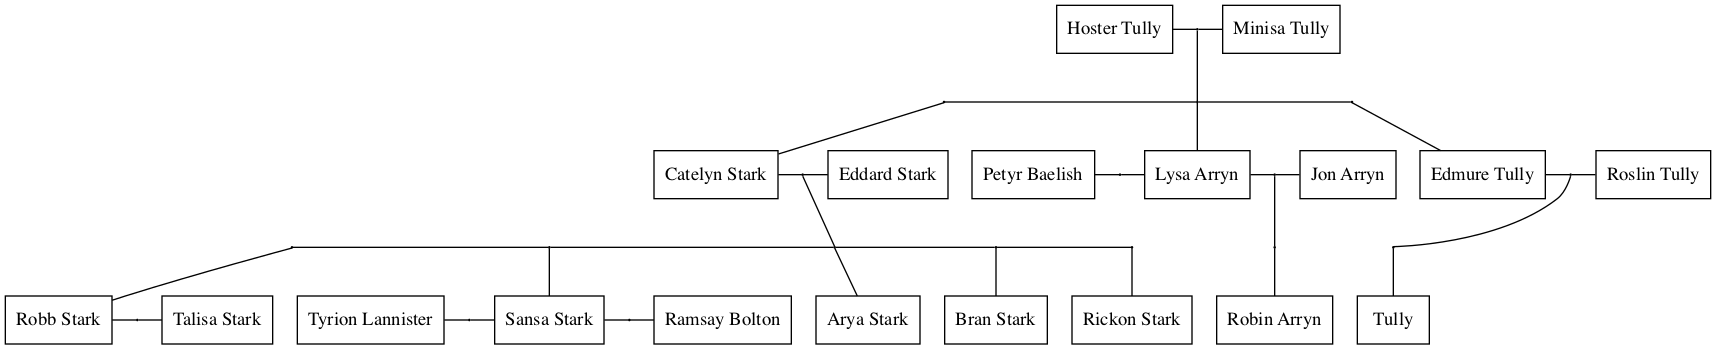



Martell Family Tree


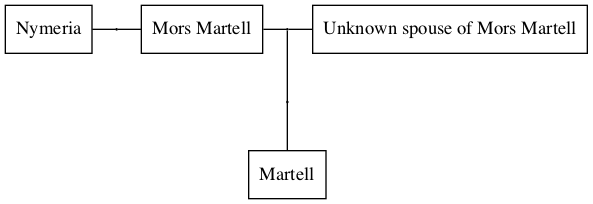

In [73]:
house_name = ['Stark', 'Lannister', 'Targaryen', 'Bolton', 'Baratheon','Tyrell','Arryn','Tully','Martell']
for name in house_name:
    print(name+' Family Tree')
    image_name = 'Family_Tree_' + name + '.png'
    display(Image(filename=image_name))
    print('\n')

The extremely complex relationships between characters in this series made it a bit difficult to draw the family trees. Some characters are marrying and/or having children with their siblings, some characters have so many different spouses that the program could not include all of them, and some technicalities with bastard children made it difficult to draw trees that accurately describe the families. However, it is very interesting to look at the final results and see how all of the families somehow connect to each other.

## 4. Discussion

Most things went really well when creating the project but there were several things that could have been improved. For one, many characters have allegiances to multiple houses since many of the families are very connected. Some of the allegiances can be forced (for example through marriage) and some of them can be former allegiances and therefore may not show the true allegiance of the character. This may have affected some of the results that were split up by houses, for example the word clouds and the sentiment analysis. A possible solution to this could have been to split the allegiances up into categories. 

The family tree was a bit more difficult to develop than anticipated, the analysis was done using a program called Gramps. The code did not work spotlessly, so some improvements needed to be made in the code for it to work for our use case. Even though the improvements were made, the code did not work perfectly and the code did not react well to edge cases. That is for example when siblings had children together and when characters had multiple spouses. As a result, some of the trees did not look that great.

On the other hand, the overall implementation of the word clouds as well as the sentiment analysis worked seamlessly and showed very good results, in spite of the allegiance issue. The showing of who had the most blood on their hand also worked quite well, but for most of the characters, their killer was unknown and therefore the results might be more accurate with more data.

## 5. Contributions

The team tried to split up most of the tasks and therefore assigned a leader to each task, but were in constant communication and helped each other out when problems arouse. Hildur took lead in the data preprocessing and creating the network, as well as the wordclouds. Pálína then took lead in doing the sentiment anlaysis and who had the most blood on their hands. Hildur started working on the family tree on her own, but it ended up being a harder task than anticipated, and therefore we ended up doing that part together. We planned the design of the website together but Pálína did most of the coding for the website. 